In [ ]:
import json
from typing import Dict, List, Tuple
import statistics
import matplotlib.pyplot as plt

model_prices = {
    "gpt-3.5-turbo-1106": {"prompt": 0.5/1000000, "completion": 1.5/1000000},
    "gpt-3.5-turbo-0613": {"prompt": 0.5/1000000, "completion": 1.5/1000000},
    "azure_gpt-35-turbo-0613": {"prompt": 0.5/1000000, "completion": 1.5/1000000},
    "gpt-4-turbo-2024-04-09": {"prompt": 10/1000000, "completion": 30/1000000},
    "gpt-4-1106-preview": {"prompt": 10/1000000, "completion": 30/1000000},
    "gpt-4-0125": {"prompt": 10/1000000, "completion": 30/1000000},
    "gpt-3.5-turbo-0125": {"prompt": 0.5/1000000, "completion": 1.5/1000000},  # Add prices for other models
    "gpt-35-turbo": {"prompt": 0.5/1000000, "completion": 1.5/1000000},  # Add prices for other models
    "codellama/CodeLlama-34b-Instruct-hf": {"prompt": 0.776/1000000, "completion": 0.776/1000000},
    "gpt-4-0613": {"prompt": 30/1000000, "completion": 60/1000000},
    'meta-llama/Llama-3-8b-chat-hf': {"prompt": 0.2/1000000, "completion": 0.2/1000000},
    'meta-llama/Llama-3-70b-chat-hf': {"prompt": 0.9/1000000, "completion": 0.9/1000000},
    "azure-agent-eval-gpt-4": {"prompt": 10/1000000, "completion": 30/1000000},
    "azure_gpt-4-0613": {"prompt": 30/1000000, "completion": 60/1000000},
}

def analyze_log(log_file: str) -> Tuple[Dict[str, float], List[Dict[str, float]]]:
    """Analyzes a log file containing OpenAI API call data.

    Args:
        log_file: The path to the log file.

    Returns:
        A tuple containing two dictionaries:
            - aggregate_stats: A dictionary containing aggregate statistics for the entire run.
            - per_task_stats: A list of dictionaries, each containing statistics for a single task.
    """

    with open(log_file, 'r') as f:
        log_data = [json.loads(line) for line in f]

    aggregate_stats = {
        'total_time': 0.0,
        'total_inference_time': 0.0,
        'total_prompt_tokens': 0,
        'total_completion_tokens': 0,
        # these per model counts are only for webapp escalation strategy
        'total_l3_8b_prompt_tokens': 0,
        'total_l3_8b_completion_tokens': 0,
        'total_l3_70b_prompt_tokens': 0,
        'total_l3_70b_completion_tokens': 0,
        'total_gpt_35_prompt_tokens': 0,
        'total_gpt_35_completion_tokens': 0,
        'total_gpt_4_prompt_tokens': 0,
        'total_gpt_4_completion_tokens': 0,
        'total_tasks': 0,
        'total_cost': 0.0,
        'average_task_time': 0.0,
        'average_inference_time': 0.0,
        'average_prompt_tokens': 0.0,
        'average_completion_tokens': 0.0
    }
    per_task_stats = []
    # Lists to store metrics for calculating min, max, and stddev
    task_times = []
    inference_times = []
    prompt_tokens = []
    completion_tokens = []

    current_task_id = None  # Keep track of the current task ID
    for entry in log_data:
        try:
            type = entry['type']
        except:
            continue
        if entry['type'] == 'task_started':
            task_stats = {
                'task_id': entry['task_id'],
                'task_time': 0.0,  # Initialize task time
                'total_inference_time': 0.0,
                'cost': 0.0,
                'prompt_tokens': 0,
                'l3_8b_prompt_tokens': 0,
                'l3_8b_completion_tokens': 0,
                'l3_70b_prompt_tokens': 0,
                'l3_70b_completion_tokens': 0,
                'gpt_35_prompt_tokens': 0,
                'gpt_35_completion_tokens': 0,
                'gpt_4_prompt_tokens': 0,
                'gpt_4_completion_tokens': 0,
                'completion_tokens': 0,
                'total_tokens':0
            }
            per_task_stats.append(task_stats)
            current_task_id = entry['task_id']  # Update current task ID
        elif entry['type'] == 'task_finished':
            for task in per_task_stats:
                if task['task_id'] == entry['task_id']:
                    task['task_time'] = entry['task_time']  # Update task time
                    aggregate_stats['total_time'] += entry['task_time']
                    aggregate_stats['total_tasks'] += 1
                    break  
            current_task_id = None  # Reset current task ID
        elif entry['type'] == 'api_call':
            # Find the task based on the current_task_id
            for task in per_task_stats:
                if task['task_id'] == current_task_id:
                    task['total_inference_time'] += entry['inference_time']
                    task['prompt_tokens'] += entry['prompt_tokens']
                    task['completion_tokens'] += entry['completion_tokens']
                    task['total_tokens'] += entry['completion_tokens'] + entry['prompt_tokens']
                    # for escalation strategy
                    if entry['model_name'] == 'meta-llama/Llama-3-8b-chat-hf':
                        task['l3_8b_prompt_tokens'] += entry['prompt_tokens']
                        task['l3_8b_completion_tokens'] += entry['completion_tokens']
                        aggregate_stats['total_l3_8b_prompt_tokens'] += entry['prompt_tokens']
                        aggregate_stats['total_l3_8b_completion_tokens'] += entry['completion_tokens']
                    if entry['model_name'] == 'meta-llama/Llama-3-70b-chat-hf':
                        task['l3_70b_prompt_tokens'] += entry['prompt_tokens']
                        task['l3_70b_completion_tokens'] += entry['completion_tokens']
                        aggregate_stats['total_l3_70b_prompt_tokens'] += entry['prompt_tokens']
                        aggregate_stats['total_l3_70b_completion_tokens'] += entry['completion_tokens']
                    if 'gpt-3' in entry['model_name']:
                        task['gpt_35_prompt_tokens'] += entry['prompt_tokens']
                        task['gpt_35_completion_tokens'] += entry['completion_tokens']
                        aggregate_stats['total_gpt_35_prompt_tokens'] += entry['prompt_tokens']
                        aggregate_stats['total_gpt_35_completion_tokens'] += entry['completion_tokens']   
                    if 'gpt-4' in entry['model_name']:
                        task['gpt_4_prompt_tokens'] += entry['prompt_tokens']
                        task['gpt_4_completion_tokens'] += entry['completion_tokens']
                        aggregate_stats['total_gpt_4_prompt_tokens'] += entry['prompt_tokens']
                        aggregate_stats['total_gpt_4_completion_tokens'] += entry['completion_tokens']
                    task['cost'] += entry['prompt_tokens'] * model_prices[entry['model_name']]['prompt'] + entry['completion_tokens'] * model_prices[entry['model_name']]['completion']
                    aggregate_stats['total_inference_time'] += entry['inference_time']
                    aggregate_stats['total_prompt_tokens'] += entry['prompt_tokens']
                    aggregate_stats['total_completion_tokens'] += entry['completion_tokens']
                    aggregate_stats['total_cost'] += entry['prompt_tokens'] * model_prices[entry['model_name']]['prompt'] + entry['completion_tokens'] * model_prices[entry['model_name']]['completion']
                    break 
        elif entry['type'] == 'run_finished':
            aggregate_stats['accuracy'] = entry['accuracy']

    aggregate_stats['average_task_time'] = aggregate_stats['total_time'] / aggregate_stats['total_tasks']
    aggregate_stats['average_inference_time'] = aggregate_stats['total_inference_time'] / aggregate_stats['total_tasks']
    aggregate_stats['average_prompt_tokens'] = aggregate_stats['total_prompt_tokens'] / aggregate_stats['total_tasks']
    aggregate_stats['average_completion_tokens'] = aggregate_stats['total_completion_tokens'] / aggregate_stats['total_tasks']

    # Calculate min, max, and stddev for aggregate stats from per_task_stats
    task_times = [task['task_time'] for task in per_task_stats]
    inference_times = [task['total_inference_time'] for task in per_task_stats]
    prompt_tokens = [task['prompt_tokens'] for task in per_task_stats]
    completion_tokens = [task['completion_tokens'] for task in per_task_stats]
    total_tokens = [task['prompt_tokens']+task['completion_tokens'] for task in per_task_stats]
    total_cost = [task['cost'] for task in per_task_stats]

    # Calculate min, max, and stddev for aggregate stats
    aggregate_stats['min_cost'] = min(total_cost)
    aggregate_stats['max_cost'] = max(total_cost)
    aggregate_stats['stddev_cost'] = statistics.stdev(total_cost)

    # Calculate min, max, and stddev for aggregate stats
    aggregate_stats['min_task_time'] = min(task_times)
    aggregate_stats['max_task_time'] = max(task_times)
    aggregate_stats['stddev_task_time'] = statistics.stdev(task_times)

    aggregate_stats['min_inference_time'] = min(inference_times)
    aggregate_stats['max_inference_time'] = max(inference_times)
    aggregate_stats['stddev_inference_time'] = statistics.stdev(inference_times)
    # median inference time
    aggregate_stats['median_inference_time'] = statistics.median(inference_times)

    aggregate_stats['min_prompt_tokens'] = min(prompt_tokens)
    aggregate_stats['max_prompt_tokens'] = max(prompt_tokens)
    aggregate_stats['stddev_prompt_tokens'] = statistics.stdev(prompt_tokens)

    aggregate_stats['min_completion_tokens'] = min(completion_tokens)
    aggregate_stats['max_completion_tokens'] = max(completion_tokens)
    aggregate_stats['stddev_completion_tokens'] = statistics.stdev(completion_tokens)

    aggregate_stats['min_total_tokens'] = min(total_tokens)
    aggregate_stats['max_total_tokens'] = max(total_tokens)
    aggregate_stats['stddev_total_tokens'] = statistics.stdev(total_tokens)

    return aggregate_stats, per_task_stats

# Example usage:
if __name__ == '__main__':
    aggregate_stats, per_task_stats = analyze_log('LanguageAgentTreeSearch/output_data/lats/humaneval/gpt-3.5-turbo-0613/run1/humaneval-py._mcts_gpt-3.5-turbo-0613.log')
    print("Aggregate Statistics:")
    print(aggregate_stats)
    print("\nPer-Task Statistics:")
    for task_stats in per_task_stats:
        print(task_stats)

In [ ]:
import json
import os
import pandas as pd
import statistics
from typing import Dict, List, Tuple

def analyze_logs_from_roots(root_dirs: List[str]) -> pd.DataFrame:
    """Analyzes log files from multiple root directories and stores results in a DataFrame.

    Args:
        root_dirs: A list of root directory paths.

    Returns:
        A Pandas DataFrame containing aggregate statistics for each log file.
    """

    all_aggregate_stats = []
    for root_dir in root_dirs:
        for dirpath, dirnames, filenames in os.walk(root_dir):
            for filename in filenames:
                if filename.endswith(".log"):
                    log_path = os.path.join(dirpath, filename)
                    aggregate_stats, _ = analyze_log(log_path)
                    # Add a column to specify the location of the log file
                    aggregate_stats['location'] = dirpath
                    all_aggregate_stats.append(aggregate_stats)

    df = pd.DataFrame(all_aggregate_stats)

    # Split 'location' column into separate columns for each path level
    location_levels = df['location'].str.split('/', expand=True)
    max_levels = location_levels.shape[1]  # Get the maximum number of path levels
    # Rename columns to "level_1", "level_2", etc.
    location_levels.columns = [f"level_{i+1}" for i in range(max_levels)]

    # only keep the last levels
    location_levels = location_levels.iloc[:, -4:]

    # rename the columns
    location_levels.columns = ['strategy', 'dataset', 'model', 'run']

    # Concatenate the split levels with the original DataFrame
    df = pd.concat([df, location_levels], axis=1)
    df = df.drop('location', axis=1) 
    # If model is codellama replace cell value with 'Escalation strategy'
    df['model'] = df['model'].replace('CodeLlama-34b-Instruct-hf', 'CL > GPT3.5 > GPT4')

    # add total_inference_time and total_cost of simple to ldb for same run and model
    for index, row in df.iterrows():
        if row['strategy'] == 'simple':
            simple_inference_time = row['total_inference_time']
            simple_cost = row['total_cost']
            simple_model = row['model']
            simple_dataset = row['dataset']
            simple_run = row['run']
            for index2, row2 in df.iterrows():
                if row2['strategy'] == 'ldb' and simple_model == row2['model'].split('+')[1] and row2['run'] == simple_run and row2['dataset'] == simple_dataset:
                    print(row['strategy'], simple_model, simple_run)
                    print(row2['strategy'], row2['model'], row2['run'])
                    print(row2['total_cost'], simple_cost)
                    df.at[index2, 'total_inference_time'] += simple_inference_time
                    df.at[index2, 'total_cost'] += simple_cost
                    print(df.at[index2, 'total_cost'])

                    

    # add total_inference_time and total_cost of reflexion to ldb for same run and model, if ldb modelname includes "reflexion"
    for index, row in df.iterrows():
        if row['strategy'] == 'reflexion':
            simple_inference_time = row['total_inference_time']
            simple_cost = row['total_cost']
            simple_model = row['model']
            simple_dataset = row['dataset']
            simple_run = row['run']
            for index2, row2 in df.iterrows():
                if "gpt-4" in simple_model:
                    if row2['strategy'] == 'ldb' and simple_model == row2['model'].split('+')[0] and row2['run'] == simple_run and row2['dataset'] == simple_dataset and 'reflexion' in row2['model']:
                        print(row2['strategy'], row2['model'], row2['run'])
                        print(row2['total_cost'], simple_cost)
                        df.at[index2, 'total_inference_time'] += simple_inference_time
                        df.at[index2, 'total_cost'] += simple_cost
                        print(df.at[index2, 'total_cost'])
                    elif row2['strategy'] == 'ldb' and "gpt-4-0613" == simple_model and "0613" in row2['model'] and row2['run'] == simple_run and row2['dataset'] == simple_dataset and 'reflexion' in row2['model']:
                        print(row2['strategy'], row2['model'], row2['run'])
                        print(row2['total_cost'], simple_cost)
                        df.at[index2, 'total_inference_time'] += simple_inference_time
                        df.at[index2, 'total_cost'] += simple_cost
                        print(df.at[index2, 'total_cost'])
                    elif row2['strategy'] == 'ldb' and "gpt-4-turbo-2024-04-09" == simple_model and "0125" in row2['model'] and row2['run'] == simple_run and row2['dataset'] == simple_dataset and 'reflexion' in row2['model']:
                        print(row2['strategy'], row2['model'], row2['run'])
                        print(row2['total_cost'], simple_cost)
                        df.at[index2, 'total_inference_time'] += simple_inference_time
                        df.at[index2, 'total_cost'] += simple_cost
                        print(df.at[index2, 'total_cost'])
                else:
                    pass
                    
    return df 

# Example usage:
if __name__ == '__main__':
    root_directories = ['LLMDebugger/output_data/simple', 
                        'LLMDebugger/output_data/ldb', 
                        'LLMDebugger/output_data/simple_boosting',
                        "reflexion/output_data",
                        "LLMDebugger/output_data/simple_incr_temp",
                        "LLMDebugger/output_data/simple_repeat",
                        "LanguageAgentTreeSearch/output_data/lats"
                        ]  # Replace with your actual root directories
    data = analyze_logs_from_roots(root_directories)
    # store the dataframe
    data.to_csv('LLMDebugger/output_data/humaneval_results.csv', index=False)
    

In [3]:
# filter lats with gpt4 0125
data = data[~((data['strategy'] == 'lats') & (data['model'] == 'gpt-4-turbo-0125'))].reset_index(drop=True)

# filter reflexion with gpt3.5
data = data[~((data['strategy'] == 'reflexion') & (data['model'] == 'gpt-3.5-turbo-0125'))].reset_index(drop=True)
data = data[~((data['strategy'] == 'reflexion') & (data['model'] == 'gpt-3.5-turbo-0613'))].reset_index(drop=True)

# filter non-relevant reflexion runs
data = data[~(data['strategy'] == 'simple_reflexion')]
data = data[~(data['strategy'] == 'simple_reflexion_ldb_nogiventests')]
data = data[~(data['strategy'] == 'simple_reflexion_ldb_nogiventests_hint_thattaskisindocstring')]
data = data[~(data['strategy'] == 'simple_reflexion_ldb_nogiventests_hint_thattaskisindocstring_stateexamples')]
              

# Select agents for analysis
data_0409 = data[data['model'].isin(['gpt-3.5-turbo-0125', 
                                'gpt-4-turbo-2024-04-09', 
                                "l3_8b-gpt35-l3_70b-gpt4-0409",
                                "gpt-4-turbo-0409-5repeats-no-temp-incr",
                                "gpt-4-turbo-0409-5step", 
                                "gpt-3.5-turbo-0125+gpt-4-turbo-2024-04-09", 
                                'gpt-4-turbo-2024-04-09+gpt-4-turbo-2024-04-09',
                                'gpt-3.5-turbo-0125+gpt-3.5-turbo-0125',
                                "gpt-3.5-turbo-0125+reflexion", 
                                "gpt-4-turbo-2024-04-09+reflexion"])]

data_0613 = data[data['model'].isin(["gpt-3.5-turbo-0613",
                                     "gpt-4-0613", 
                                     "gpt-4-0613+gpt-4-0613",
                                     "gpt-3.5-turbo-0613+gpt-4-0613",
                                     "gpt-3.5-turbo-0613+gpt-3.5-turbo-0613",
                                     "gpt-3.5-turbo-0613+reflexion",
                                     "gpt-4-0613-5repeats-no-temp-incr",
                                     "gpt-3.5-turbo-0613-5repeats-no-temp-incr",
                                     "gpt-4-0613-5step", 
                                     "gpt-3.5-turbo-0613-5step", 
                                     "gpt-4-0613+reflexion", 
                                     "l3_8b-gpt-3.5-turbo-0613-l3_70b-gpt4-0613"])]


data_0409.to_csv("plot_data_0409.csv", index=False)
data_0613.to_csv("plot_data_0613.csv", index=False)

## HumanEval

## MinMax error bars

### 0409

/tmp/ipykernel_2878931/2073686339.py:177: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = plt.scatter([], [], c=color, marker='o')


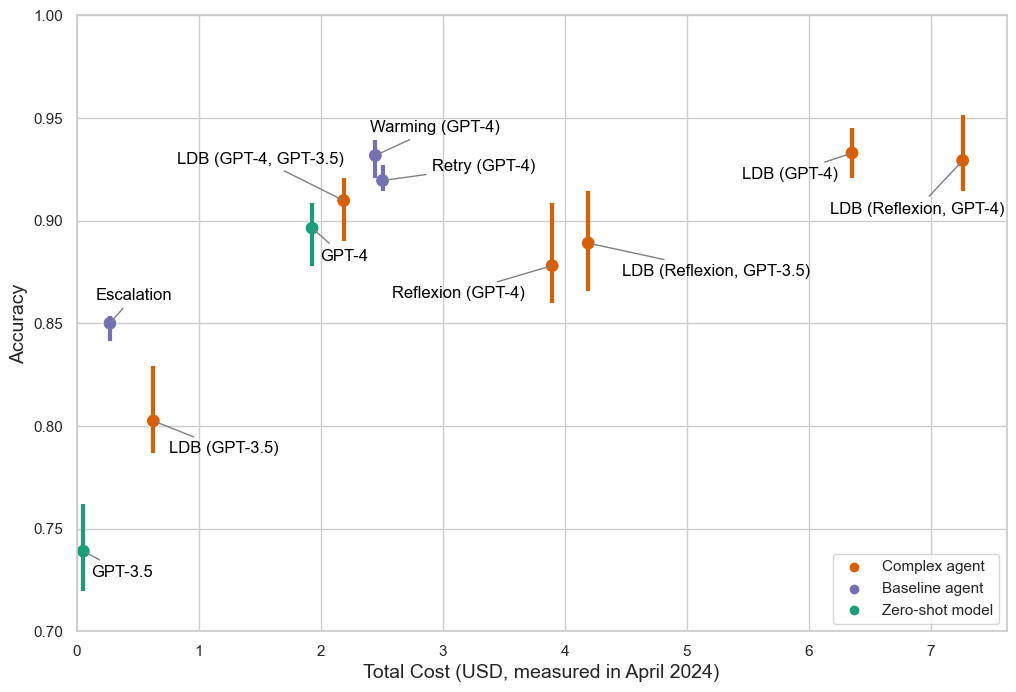

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")
# Set the context for plotting 
sns.set_context("notebook", font_scale=1)  #

# Load the data
data = pd.read_csv('plot_data_0409.csv')

# Drop LATS
data = data[~((data['strategy'] == 'lats'))].reset_index(drop=True)


# Map the old strategy names to the new names
strategy_renames = {
    "ldb": "LDB",
    "lats": "LATS",
    "simple": "",
    "simple_boosting": "Escalation",
    "simple_incr_temp": "Warming",
    "reflexion": "Reflexion",
    "simple_repeat": "Retry"
}
data['strategy_renamed'] = data['strategy'].map(strategy_renames)

# Replace model names with more readable names
model_renames = {
    "gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-3.5-turbo-0125+gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-2024-04-09+gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-0125": "GPT-4",
    "l3_8b-gpt35-l3_70b-gpt4": "gpt",
    "l3_8b-gpt35-l3_70b-gpt4-0409": "gpt",
    "gpt-4-turbo-0125": "GPT-4",
    "gpt-4-turbo-0409-5step": "GPT-4",
     "gpt-4-turbo-0409-1step": "GPT-4-1step",
     "gpt-4-turbo-0125-8repeats-no-temp-incr": "GPT-4",
     "gpt-4-turbo-2024-04-09+reflexion": "GPT-4+reflexion",
     "gpt-3.5-turbo-0125+reflexion": "GPT-3.5+reflexion",
     "gpt-4-turbo-0409-5repeats-no-temp-incr": "GPT-4",
     "gpt-3.5-turbo-0125+gpt-4-turbo-2024-04-09": "GPT-4, GPT-3.5",
    # "CL > GPT3.5 > GPT4": "CodeLlama"
}
data['model'] = data['model'].map(model_renames)

# Add model name to the strategy name
for i in range(data.shape[0]):
    if strategy_renames[data['strategy'][i]] == "":
        data.loc[i, 'strategy_renamed'] = data['model'][i]
    elif strategy_renames[data['strategy'][i]] == "Escalation":
        data.loc[i, 'strategy_renamed'] = "Escalation"
    else:
        data.loc[i, 'strategy_renamed'] = str(data['strategy_renamed'][i]) + " (" + str(data['model'][i]) + ")"
    #if strategy is ldb and model contains reflexion, then add reflexion to the strategy name
    if data['strategy'][i] == "ldb" and "reflexion" in data['model'][i]:
        data.loc[i, 'strategy_renamed'] = "LDB" + " (" + "Reflexion, " + str(data['model'][i]).replace("+reflexion", "") + ")"


blue = sns.color_palette("Dark2")[0]
orange = sns.color_palette("Dark2")[1]
green = sns.color_palette("Dark2")[2]

color_dict = {'GPT-4': blue,
 'GPT-3.5': blue,
 'LDB (GPT-4)': orange,
 'LDB (GPT-3.5)': orange,
 'Escalation': green,
 'Reflexion (GPT-4)': orange,
 "LATS (GPT-4, GPT-3.5)": orange,
 "Retry (GPT-4)": green,
 "Warming (GPT-4-1step)": blue,
 "LDB (Reflexion, GPT-4)": orange,
 "LDB (GPT-4, GPT-3.5)": orange,
 "LATS (GPT-4)": orange,
 "LATS (GPT-3.5)": orange,
 "LDB (Reflexion, GPT-3.5)": orange,
"Warming (GPT-4)": green,
'GPT-4': blue,
 'GPT-3.5': blue,
 'LDB (GPT-4)': orange,
 'LDB (GPT-3.5)': orange,
 'Escalation': green,
 'Reflexion (GPT-4)': orange,
 "LATS (GPT-3.5)": orange,
 "Retry (GPT-4)": green,
 "Warming (GPT-4-1step)": blue,
 "LDB (GPT-4, Reflexion)": orange,
 "LDB (GPT-3.5, GPT-4)": orange,
 "LATS (GPT-4)": orange,
 "LDB (GPT-3.5, Reflexion)": orange,
 "Reflexion (GPT-3.5)": orange,
 "Repeat (GPT-3.5)": green,
"Warming (GPT-4)": green}

markers_dict = {
    'GPT-4': 's',  # Square
    'GPT-3.5': 's',  # Square
    'LDB (GPT-4)': 'o',  # Circle
    'LDB (GPT-3.5)': 'o',  # Circle
    'Escalation': 'X',  # X
    'Reflexion (GPT-4)': 'o',  # Circle
    "LATS (GPT-4, GPT-3.5)": 'o',  # Circle
    "Retry (GPT-4)": 'X',  # X
    "Warming (GPT-4-1step)": 'X',  # X
    "LDB (Reflexion, GPT-4)": 'o',  # Circle
    "LDB (GPT-4, GPT-3.5)": 'o',  # Circle
    "LATS (GPT-4)": 'o',  # Circle
    "LATS (GPT-3.5)": 'o',  # Circle
    "LDB (Reflexion, GPT-3.5)": 'o',  # Circle
    "Warming (GPT-4)": 'X',  # X
    "LATS (GPT-3.5)": 'o',  # Circle
    "Retry (GPT-4)": 'X',  # X
    "Warming (GPT-4-1step)": 'X',  # X
    "LDB (GPT-4, Reflexion)": 'o',  # Circle
    "LDB (GPT-3.5, GPT-4)": 'o',  # Circle
    "LATS (GPT-4)": 'o',  # Circle
    "LDB (GPT-3.5, Reflexion)": 'o',  # Circle
    "Reflexion (GPT-3.5)": 'o',  # Circle
    "Repeat (GPT-3.5)": 'X',  # X
    "Warming (GPT-4)": 'X',  # X
}


# # Change colors of points based on strategy and model
# scatter_plot = sns.scatterplot(data=data, x='total_cost', y='accuracy', hue='strategy_renamed', palette=color_dict,
#                                 marker='o', s=200, legend=None)


# Group data by model and strategy, calculating mean and error bar ranges
grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    min_accuracy=('accuracy', 'min'),
    max_accuracy=('accuracy', 'max'),
    mean_cost=('total_cost', 'mean')
).reset_index()

# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper'] = grouped_data['max_accuracy'] - grouped_data['mean_accuracy']
grouped_data['yerr_lower'] = grouped_data['mean_accuracy'] - grouped_data['min_accuracy']


# Create the scatter plot with error bars
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    data=grouped_data, 
    x='mean_cost', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    marker='o', 
    s=100, 
    legend=None
)

# change color of the error bars
for i in range(len(grouped_data)):
    plt.errorbar(
        x=grouped_data['mean_cost'][i], 
        y=grouped_data['mean_accuracy'][i], 
        yerr=[[grouped_data['yerr_lower'][i]], [grouped_data['yerr_upper'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=color_dict[grouped_data['strategy_renamed'][i]],  # Use the same color as the scatter plot
        capsize=0,  # Add caps to the error bars
        elinewidth=3  # Adjust error bar line width
    )

# LEGEND
colors = [orange, green, blue]
labels = ['Complex agent', 'Baseline agent', 'Zero-shot model']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    handle = plt.scatter([], [], c=color, marker='o')
    legend_handles.append(handle)
plt.legend(handles=legend_handles, labels=labels, loc="lower right")


# Setting the title and labels
# plt.title('Accuracy vs. Cost per Model and Agent on HumanEval', fontsize=16, pad=15)
plt.xlabel('Total Cost (USD, measured in April 2024)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)


# Setting the y-axis limits
plt.ylim(0.7, 1)
plt.xlim(0,)
# plt.xscale('log', base=10)

data = grouped_data
# Implementing label adjustments using simple lines
for i in range(data.shape[0]):
    annotation_text = data.strategy_renamed[i]
    x = data.mean_cost[i]
    y = data.mean_accuracy[i]
    if data.strategy_renamed[i] == "Escalation":
        xytext = (45, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-3.5":
        xytext = (50, -15)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5)":
        xytext = (90, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4)":
        xytext = (-10, -15)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-3.5)":
        xytext = (160, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-4)":
        xytext = (30, -35)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4, GPT-3.5)":
        xytext = (0, 30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-3.5)":
        xytext = (110, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-4)":
        xytext = (-20, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4)":
        xytext = (90, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4-1step)":
        xytext = (10, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Retry (GPT-4)":
        xytext = (110,10)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-4":
        xytext = (40,-20)  # "Escalation" above the point
        ha = 'right'
    else:
        xytext = (30, -20)  # other strategies below the point to the right
        ha = 'right'

    scatter_plot.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=12, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))

plt.show()


### 0613

/tmp/ipykernel_2878931/2881649835.py:130: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = plt.scatter([], [], c=color, marker='o')


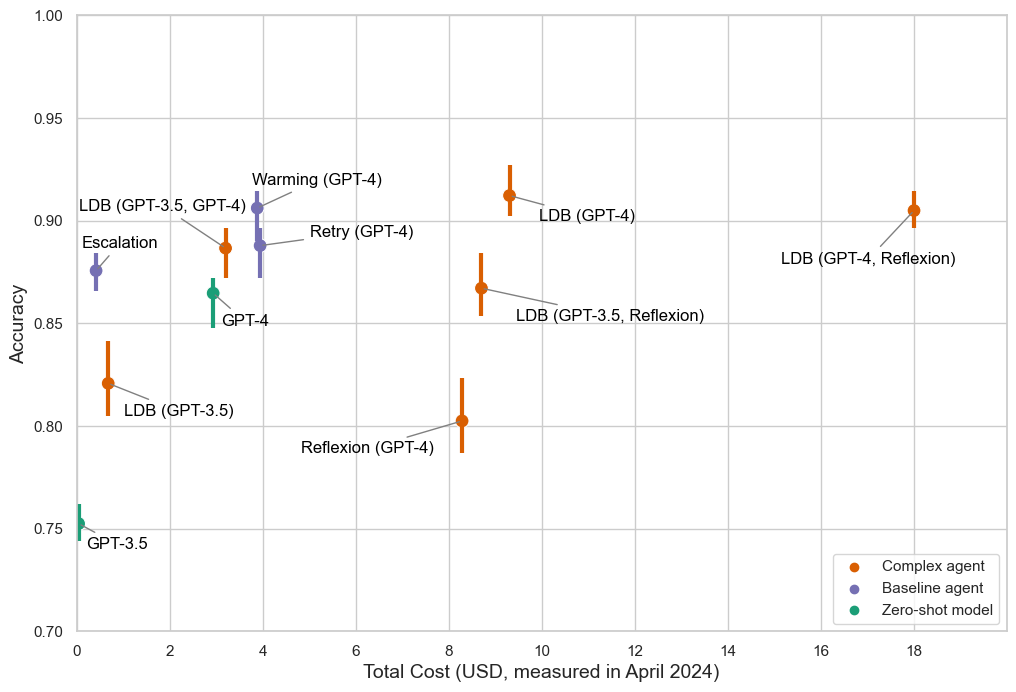

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")
# Set the context for plotting 
sns.set_context("notebook", font_scale=1)  #

# Load the data
data = pd.read_csv('plot_data_0613.csv')

# Drop LATS
data = data[~((data['strategy'] == 'lats'))].reset_index(drop=True)


# Map the old strategy names to the new names
strategy_renames = {
    "ldb": "LDB",
    "lats": "LATS",
    "simple": "",
    "simple_boosting": "Escalation",
    "simple_incr_temp": "Warming",
    "reflexion": "Reflexion",
    "simple_repeat": "Retry"
}
data['strategy_renamed'] = data['strategy'].map(strategy_renames)

# Replace model names with more readable names
model_renames = {
    "gpt-3.5-turbo-0613": "GPT-3.5",
    "gpt-3.5-turbo-0613+gpt-3.5-turbo-0613": "GPT-3.5",
    "gpt-4-0613": "GPT-4", 
    "gpt-3.5-turbo-0613+reflexion": "GPT-3.5+reflexion",
    "gpt-3.5-turbo-0613+gpt-4-0613": "GPT-3.5, GPT-4",
    "gpt-4-0613+reflexion": "GPT-4+reflexion", 
    "l3_8b-gpt-3.5-turbo-0613-l3_70b-gpt4-0613": "gpt",
    "gpt-4-0613-5repeats-no-temp-incr": "GPT-4",
    "gpt-4-0613+gpt-4-0613": "GPT-4",
    "gpt-4-0613-5step": "GPT-4",
    # "gpt-3.5-turbo-0613-5repeats-no-temp-incr": "GPT-3.5",
    # "CL > GPT3.5 > GPT4": "CodeLlama"
}
data['model'] = data['model'].map(model_renames)

# Add model name to the strategy name
for i in range(data.shape[0]):
    if strategy_renames[data['strategy'][i]] == "":
        data.loc[i, 'strategy_renamed'] = data['model'][i]
    elif strategy_renames[data['strategy'][i]] == "Escalation":
        data.loc[i, 'strategy_renamed'] = "Escalation"
    else:
        data.loc[i, 'strategy_renamed'] = str(data['strategy_renamed'][i]) + " (" + str(data['model'][i]) + ")"
    #if strategy is ldb and model contains reflexion, then add reflexion to the strategy name
    if data['strategy'][i] == "ldb" and "reflexion" in data['model'][i]:
        data.loc[i, 'strategy_renamed'] = "LDB" + " (" + str(data['model'][i]).replace("+reflexion", "") + ", Reflexion" + ")"


blue = sns.color_palette("Dark2")[0]
orange = sns.color_palette("Dark2")[1]
green = sns.color_palette("Dark2")[2]

# color_dict = {'GPT-4': blue,
#  'GPT-3.5': blue,
#  'LDB (GPT-4)': orange,
#  'LDB (GPT-3.5)': orange,
#  'Escalation': green,
#  'Reflexion (GPT-4)': orange,
#  "LATS (GPT-3.5)": orange,
#  "Retry (GPT-4)": green,
#  "Warming (GPT-4-1step)": blue,
#  "LDB (GPT-4, Reflexion)": orange,
#  "LDB (GPT-3.5, GPT-4)": orange,
#  "LATS (GPT-4)": orange,
#  "LDB (GPT-3.5, Reflexion)": orange,
#  "Reflexion (GPT-3.5)": orange,
#  "Repeat (GPT-3.5)": green,
# "Warming (GPT-4)": green}


# # Change colors of points based on strategy and model
# scatter_plot = sns.scatterplot(data=data, x='total_cost', y='accuracy', hue='strategy_renamed', palette=color_dict,
#                                 marker='o', s=200, legend=None)


# Group data by model and strategy, calculating mean and error bar ranges
grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    min_accuracy=('accuracy', 'min'),
    max_accuracy=('accuracy', 'max'),
    mean_cost=('total_cost', 'mean')
).reset_index()

# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper'] = grouped_data['max_accuracy'] - grouped_data['mean_accuracy']
grouped_data['yerr_lower'] = grouped_data['mean_accuracy'] - grouped_data['min_accuracy']


# Create the scatter plot with error bars
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    data=grouped_data, 
    x='mean_cost', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    marker='o', 
    s=100, 
    legend=None
)

# change color of the error bars
for i in range(len(grouped_data)):
    plt.errorbar(
        x=grouped_data['mean_cost'][i], 
        y=grouped_data['mean_accuracy'][i], 
        yerr=[[grouped_data['yerr_lower'][i]], [grouped_data['yerr_upper'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=color_dict[grouped_data['strategy_renamed'][i]],  # Use the same color as the scatter plot
        capsize=0,  # Add caps to the error bars
        elinewidth=3  # Adjust error bar line width
    )

# LEGEND
colors = [orange, green, blue]
labels = ['Complex agent', 'Baseline agent', 'Zero-shot model']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    handle = plt.scatter([], [], c=color, marker='o')
    legend_handles.append(handle)
plt.legend(handles=legend_handles, labels=labels, loc="lower right")


# Setting the title and labels
# plt.title('Accuracy vs. Cost per Model and Agent on HumanEval', fontsize=16, pad=15)
plt.xlabel('Total Cost (USD, measured in April 2024)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)


# Setting the y-axis limits
plt.ylim(0.7, 1)
plt.xlim(0,20)
plt.xticks(range(0,20,2))
# plt.xscale('log', base=10)

data = grouped_data
# Implementing label adjustments using simple lines
for i in range(data.shape[0]):
    annotation_text = data.strategy_renamed[i]
    x = data.mean_cost[i]
    y = data.mean_accuracy[i]
    if data.strategy_renamed[i] == "Escalation":
        xytext = (45, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-3.5":
        xytext = (50, -15)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5)":
        xytext = (90, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4)":
        xytext = (90, -15)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5, Reflexion)":
        xytext = (160, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4, Reflexion)":
        xytext = (30, -35)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5, GPT-4)":
        xytext = (15, 30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-3.5)":
        xytext = (110, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-4)":
        xytext = (-20, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4)":
        xytext = (90, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4-1step)":
        xytext = (10, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Retry (GPT-4)":
        xytext = (110,10)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-4":
        xytext = (40,-20)  # "Escalation" above the point
        ha = 'right'
    else:
        xytext = (30, -20)  # other strategies below the point to the right
        ha = 'right'

    scatter_plot.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=12, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))

plt.show()


## with cost CI

### 0409

/tmp/ipykernel_2878931/3995147195.py:270: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = plt.scatter([], [], c=color, marker='|', s=160, linewidth=5, alpha=err_bar_alpha)
/tmp/ipykernel_2878931/3995147195.py:286: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = plt.scatter([], [], c=color, marker=m, s=50)


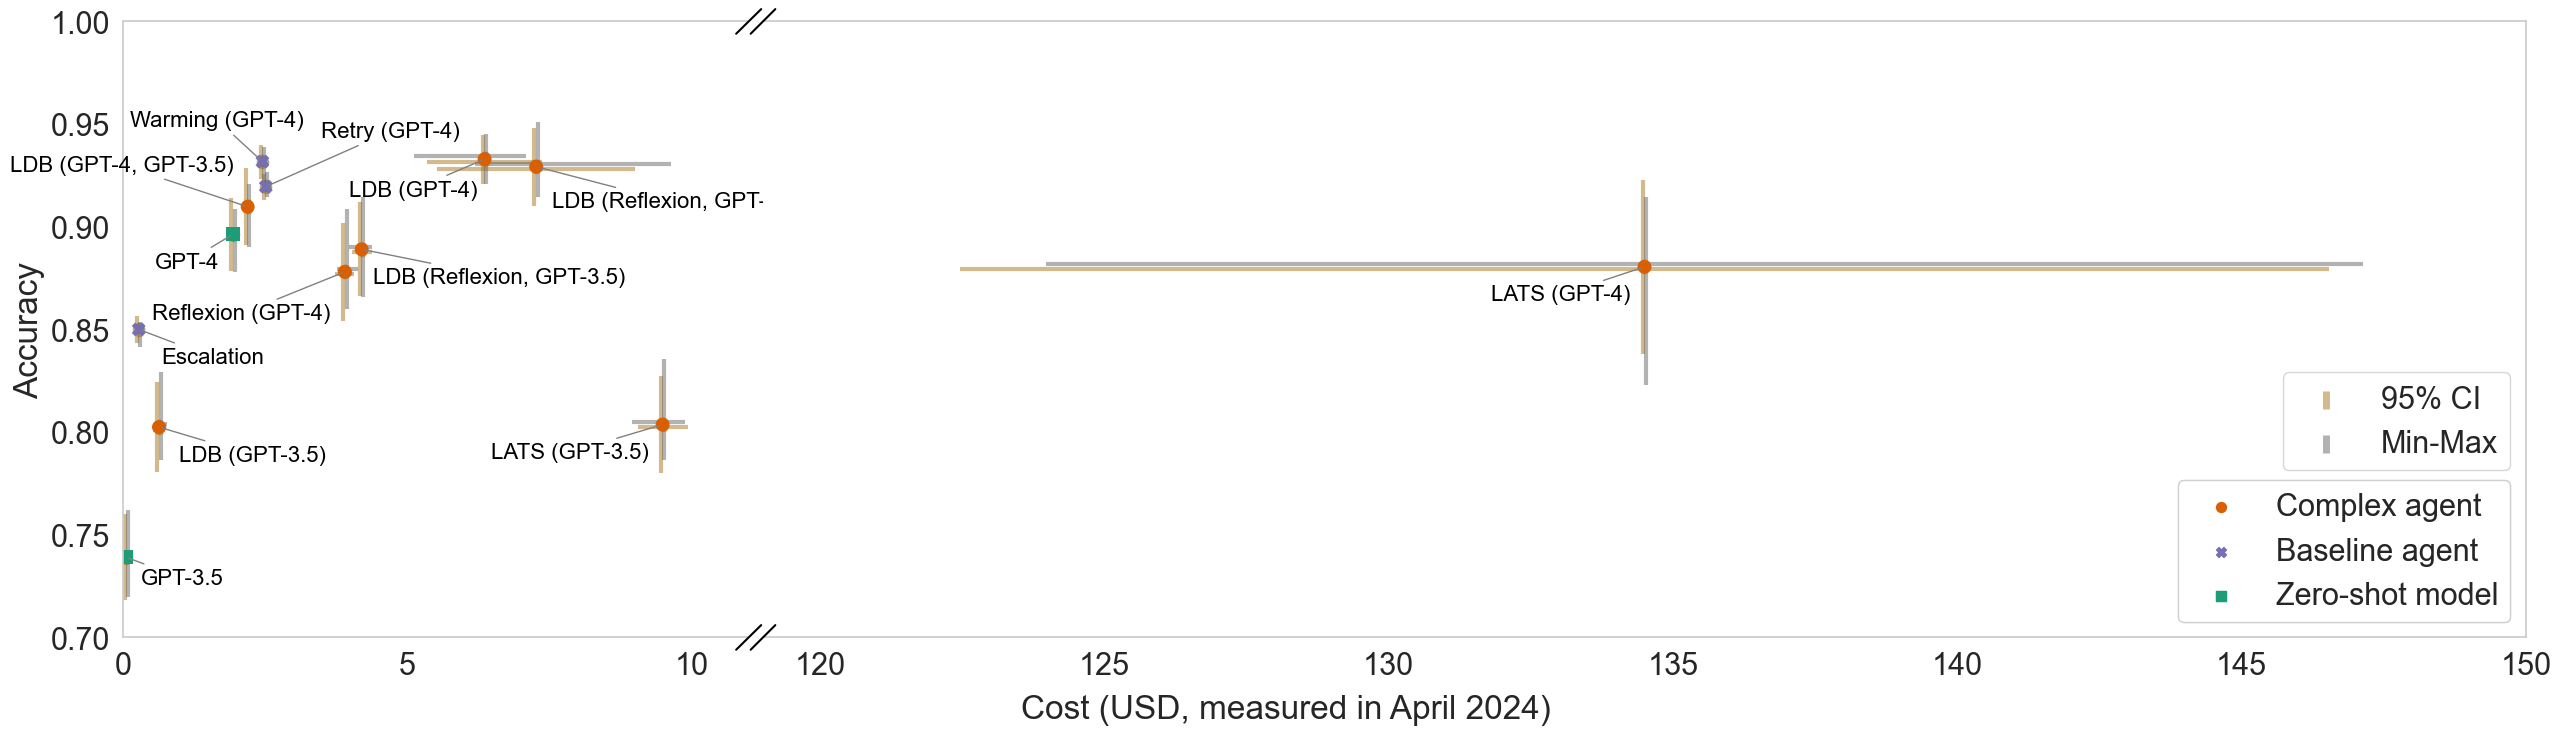

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")
# Set the context for plotting 
sns.set_context("notebook", font_scale=2)  #

# Load the data
data = pd.read_csv('plot_data_0409.csv')


# Map the old strategy names to the new names
strategy_renames = {
    "ldb": "LDB",
    "lats": "LATS",
    "simple": "",
    "simple_boosting": "Escalation",
    "simple_incr_temp": "Warming",
    "reflexion": "Reflexion",
    "simple_repeat": "Retry"
}
data['strategy_renamed'] = data['strategy'].map(strategy_renames)

# Replace model names with more readable names
model_renames = {
    "gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-3.5-turbo-0125+gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-2024-04-09+gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-0125": "GPT-4",
    "l3_8b-gpt35-l3_70b-gpt4": "gpt",
    "l3_8b-gpt35-l3_70b-gpt4-0409": "gpt",
    "gpt-4-turbo-0125": "GPT-4",
    "gpt-4-turbo-0409-5step": "GPT-4",
     "gpt-4-turbo-0409-1step": "GPT-4-1step",
     "gpt-4-turbo-0125-8repeats-no-temp-incr": "GPT-4",
     "gpt-4-turbo-2024-04-09+reflexion": "GPT-4+reflexion",
     "gpt-3.5-turbo-0125+reflexion": "GPT-3.5+reflexion",
     "gpt-4-turbo-0409-5repeats-no-temp-incr": "GPT-4",
     "gpt-3.5-turbo-0125+gpt-4-turbo-2024-04-09": "GPT-4, GPT-3.5",
    # "CL > GPT3.5 > GPT4": "CodeLlama"
}

data['model'] = data['model'].map(model_renames)

# Add model name to the strategy name
for i in range(data.shape[0]):
    if strategy_renames[data['strategy'][i]] == "":
        data.loc[i, 'strategy_renamed'] = data['model'][i]
    elif strategy_renames[data['strategy'][i]] == "Escalation":
        data.loc[i, 'strategy_renamed'] = "Escalation"
    else:
        data.loc[i, 'strategy_renamed'] = str(data['strategy_renamed'][i]) + " (" + str(data['model'][i]) + ")"
    #if strategy is ldb and model contains reflexion, then add reflexion to the strategy name
    if data['strategy'][i] == "ldb" and "reflexion" in data['model'][i]:
        data.loc[i, 'strategy_renamed'] = "LDB" + " (" + "Reflexion, " + str(data['model'][i]).replace("+reflexion", "") + ")"


blue = sns.color_palette("Dark2")[0]
orange = sns.color_palette("Dark2")[1]
green = sns.color_palette("Dark2")[2]
# Create the scatter plot with error bars
f, (ax, ax2) = plt.subplots(1,2, figsize=(31, 8), sharey=True, width_ratios=[11, 31])
f.subplots_adjust(wspace=0.012)

# Additional function to calculate confidence intervals for cost
def calculate_cost_confidence_interval(data):
    n = len(data)
    mean = data.mean()
    std_err = stats.sem(data)  # Standard error for the cost data
    margin_of_error = std_err * stats.t.ppf((1 + 0.95) / 2., n - 1)  # 95% CI
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    return confidence_interval

# Modify grouping to include cost confidence intervals
grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_cost=('total_cost', 'mean'),
    max_cost=('total_cost', 'max'),
    min_cost=('total_cost', 'min'),
    cost_confidence_interval=('total_cost', calculate_cost_confidence_interval)
).reset_index()


# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper_maxmin'] = grouped_data['max_cost'] - grouped_data['mean_cost']
grouped_data['yerr_lower_maxmin'] = grouped_data['mean_cost'] - grouped_data['min_cost']

# Extract cost confidence interval values for error bars
grouped_data['xerr_lower_95CI'] = grouped_data['mean_cost'] - grouped_data['cost_confidence_interval'].str[0]
grouped_data['xerr_upper_95CI'] = grouped_data['cost_confidence_interval'].str[1] - grouped_data['mean_cost']

err_bar_offset = 0.0013
err_bar_line_width = 3
err_bar_alpha=0.5
# Adding horizontal error bars for cost on the plot
for i in range(len(grouped_data)):
    ax.errorbar(
        x=grouped_data['mean_cost'][i], 
        y=grouped_data['mean_accuracy'][i] - err_bar_offset, 
        xerr=[[grouped_data['xerr_lower_95CI'][i]], [grouped_data['xerr_upper_95CI'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-2],  # Change color to gray for distinction
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width
        alpha=err_bar_alpha,  # Set transparency
        zorder=1
    )
    ax2.errorbar(
        x=grouped_data['mean_cost'][i], 
        y=grouped_data['mean_accuracy'][i] - err_bar_offset, 
        xerr=[[grouped_data['xerr_lower_95CI'][i]], [grouped_data['xerr_upper_95CI'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-2],  # Change color to gray for distinction
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width
        alpha=err_bar_alpha,  # Set transparency
        zorder=1
    )
# Adding horizontal error bars for cost on the plot
for i in range(len(grouped_data)):
    ax.errorbar(
        x=grouped_data['mean_cost'][i], 
        y=grouped_data['mean_accuracy'][i] + err_bar_offset, 
        xerr=[[grouped_data['yerr_lower_maxmin'][i]], [grouped_data['yerr_upper_maxmin'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-1],  # Change color to gray for distinction
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width
        alpha=err_bar_alpha,  # Set transparency
        zorder=1
    )
    ax2.errorbar(
        x=grouped_data['mean_cost'][i], 
        y=grouped_data['mean_accuracy'][i] + err_bar_offset, 
        xerr=[[grouped_data['yerr_lower_maxmin'][i]], [grouped_data['yerr_upper_maxmin'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-1],  # Change color to gray for distinction
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width
        alpha=err_bar_alpha,  # Set transparency
        zorder=1
    )





# Group data and calculate confidence intervals
def calculate_confidence_interval(data):
    n = len(data)
    mean = data.mean()
    std_err = stats.sem(data)  # Calculate standard error
    margin_of_error = std_err * stats.t.ppf((1 + 0.95) / 2, n - 1)  # 95% CI
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    return confidence_interval

grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    min_accuracy=('accuracy', 'min'),
    max_accuracy=('accuracy', 'max'),
    mean_cost=('total_cost', 'mean'),
    confidence_interval=('accuracy', calculate_confidence_interval)
).reset_index()


# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper_maxmin'] = grouped_data['max_accuracy'] - grouped_data['mean_accuracy']
grouped_data['yerr_lower_maxmin'] = grouped_data['mean_accuracy'] - grouped_data['min_accuracy']

# Extract confidence interval values
grouped_data['yerr_lower_95CI'] = grouped_data['mean_accuracy'] - grouped_data['confidence_interval'].str[0]
grouped_data['yerr_upper_95CI'] = grouped_data['confidence_interval'].str[1] - grouped_data['mean_accuracy']


# Create the scatter plot with error bars
scatter_plot = sns.scatterplot(
    data=grouped_data, 
    x='mean_cost', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    zorder=2,
    ax=ax,
    edgecolor='none'
)
# Create the scatter plot with error bars
scatter_plot2 = sns.scatterplot(
    data=grouped_data, 
    x='mean_cost', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    zorder=2,
    ax=ax2,
    edgecolor='none'
)


err_bar_offset = 0.03
# change color of the error bars
for i in range(len(grouped_data)):
    ax.errorbar(
        x=grouped_data['mean_cost'][i] - err_bar_offset, 
        y=grouped_data['mean_accuracy'][i], 
        yerr=[[grouped_data['yerr_lower_95CI'][i]], [grouped_data['yerr_upper_95CI'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-2],  # Use the same color as the scatter plot
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width,
        label="95% CI",
        zorder=1,
        alpha=err_bar_alpha
    )
    ax2.errorbar(
        x=grouped_data['mean_cost'][i] - err_bar_offset, 
        y=grouped_data['mean_accuracy'][i], 
        yerr=[[grouped_data['yerr_lower_95CI'][i]], [grouped_data['yerr_upper_95CI'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-2],  # Use the same color as the scatter plot
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width,
        label="95% CI",
        zorder=1,
        alpha=err_bar_alpha
    )

# change color of the error bars
for i in range(len(grouped_data)):
    ax.errorbar(
        x=grouped_data['mean_cost'][i] + err_bar_offset, 
        y=grouped_data['mean_accuracy'][i], 
        yerr=[[grouped_data['yerr_lower_maxmin'][i]], [grouped_data['yerr_upper_maxmin'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-1],  # Use the same color as the scatter plot
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width,
        label="max-min",
        zorder=1,
        alpha=err_bar_alpha
    )
    ax2.errorbar(
        x=grouped_data['mean_cost'][i] + err_bar_offset, 
        y=grouped_data['mean_accuracy'][i], 
        yerr=[[grouped_data['yerr_lower_maxmin'][i]], [grouped_data['yerr_upper_maxmin'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-1],  # Use the same color as the scatter plot
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width,
        label="max-min",
        zorder=1,
        alpha=err_bar_alpha
    )
# LEGEND
colors = [sns.color_palette("Dark2")[-2], sns.color_palette("Dark2")[-1]]
labels = ['95% CI', 'Min-Max']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    handle = plt.scatter([], [], c=color, marker='|', s=160, linewidth=5, alpha=err_bar_alpha)
    legend_handles.append(handle)
plt.gca().add_artist(plt.legend(handles=legend_handles, labels=labels, bbox_to_anchor=(1, 0.455)))

# LEGEND
colors = [orange, green, blue]
labels = ['Complex agent', 'Baseline agent', 'Zero-shot model']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    if color == orange:
        m = 'o'
    elif color == green:
        m = 'X'
    else:
        m = 's'
    handle = plt.scatter([], [], c=color, marker=m, s=50)
    legend_handles.append(handle)
plt.gca().add_artist(plt.legend(handles=legend_handles, labels=labels, loc="lower right"))


# Setting the title and labels
# plt.title('Accuracy vs. Cost per Model and Agent on HumanEval', fontsize=16, pad=15)
ax.set_ylabel('Accuracy')
# set joint x-axis label
f.text(0.5, 0.02, 'Cost (USD, measured in April 2024)', ha='center', va='center')
# remove the x-axis label from the second plot
ax2.set_xlabel('')
ax.set_xlabel('')
plt.grid(True)

# Setting the y-axis limits
plt.ylim(0.7, 1)
ax.set_xlim(0, 11)
ax2.set_xlim(119, 150)
# plt.xscale('log', base=10)

# plot ticks on x axis every 5 units
ax.set_xticks([0,5,10])
ax2.set_xticks([120, 125, 130, 135, 140, 145, 150])

ax.grid(False)
ax2.grid(False)

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), zorder=3, **kwargs)     # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), zorder=3, **kwargs)  # top-right diagonal

d = .02
kwargs.update(transform=ax2.transAxes, color='k', clip_on=False)  # switch to the bottom axes
ax2.plot((-d+0.013, +d-0.013), (- d, + d), zorder=3, **kwargs)  # bottom-left diagonal
ax2.plot((- d+0.013, + d-0.013), (1 - d, 1 + d), zorder=3,**kwargs)  # bottom-right diagonal

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

data = grouped_data
# Implementing label adjustments using simple lines
for i in range(data.shape[0]):
    annotation_text = data.strategy_renamed[i]
    x = data.mean_cost[i]
    y = data.mean_accuracy[i]
    if data.strategy_renamed[i] == "Escalation":
        xytext = (90, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-3.5":
        xytext = (70, -15)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5)":
        xytext = (120, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4)":
        xytext = (-5, -22)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4, GPT-3.5)":
        xytext = (-10, 30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-3.5)":
        xytext = (190, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-4)":
        xytext = (180, -25)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-3.5)":
        xytext = (110, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-4)":
        xytext = (-10, -30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4)":
        xytext = (30, 30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-4)":
        xytext = (-10, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-3.5)":
        xytext = (-10, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Retry (GPT-4)":
        xytext = (140,40)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-4":
        xytext = (-10,-20)  # "Escalation" above the point
        ha = 'right'
    else:
        xytext = (30, -20)  # other strategies below the point to the right
        ha = 'right'

    scatter_plot.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))
    scatter_plot2.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))

plt.savefig(f"humaneval_figures/humaneval-CIs.png", bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()

### 0613

/home/bs6865/.conda/envs/novelqa/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bs6865/.conda/envs/novelqa/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bs6865/.conda/envs/novelqa/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bs6865/.conda/envs/novelqa/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2878931/2525098343.py:204: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Plea

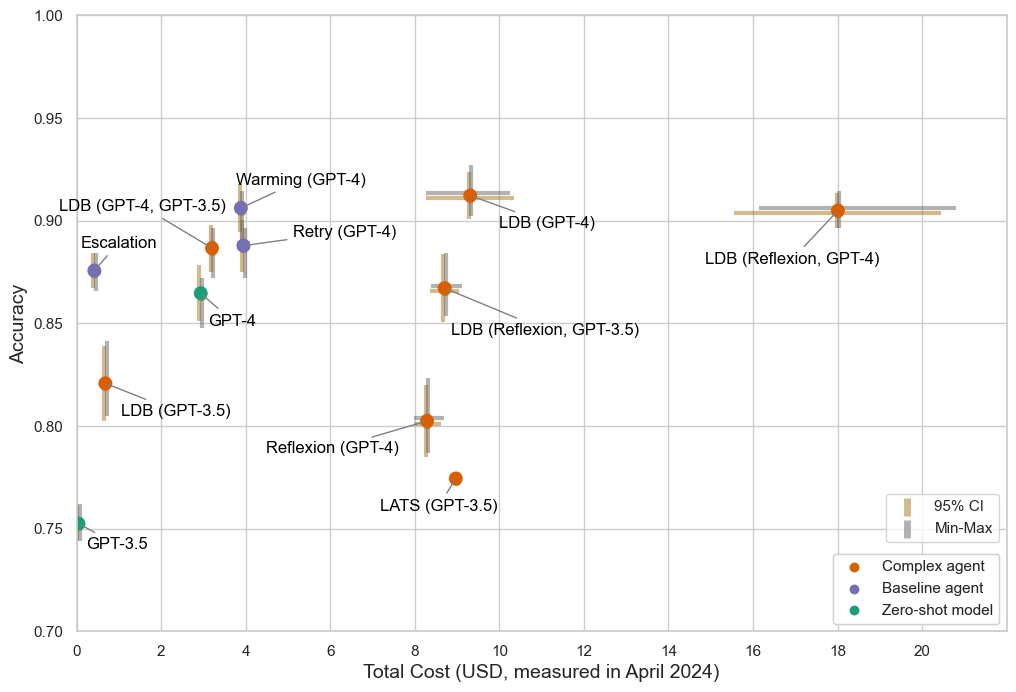

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")
# Set the context for plotting 
sns.set_context("notebook", font_scale=1)  #

# Load the data
data = pd.read_csv('plot_data_0613.csv')

# Drop LATS
# data = data[~((data['strategy'] == 'lats'))].reset_index(drop=True)

# Map the old strategy names to the new names
strategy_renames = {
    "ldb": "LDB",
    "lats": "LATS",
    "simple": "",
    "simple_boosting": "Escalation",
    "simple_incr_temp": "Warming",
    "reflexion": "Reflexion",
    "simple_repeat": "Retry"
}
data['strategy_renamed'] = data['strategy'].map(strategy_renames)

# Replace model names with more readable names
model_renames = {
    "gpt-3.5-turbo-0613": "GPT-3.5",
    "gpt-3.5-turbo-0613+gpt-3.5-turbo-0613": "GPT-3.5",
    "gpt-4-0613": "GPT-4", 
    "gpt-3.5-turbo-0613+reflexion": "GPT-3.5+reflexion",
    "gpt-3.5-turbo-0613+gpt-4-0613": "GPT-4, GPT-3.5",
    "gpt-4-0613+reflexion": "GPT-4+reflexion", 
    "l3_8b-gpt-3.5-turbo-0613-l3_70b-gpt4-0613": "gpt",
    "gpt-4-0613-5repeats-no-temp-incr": "GPT-4",
    "gpt-4-0613+gpt-4-0613": "GPT-4",
    "gpt-4-0613-5step": "GPT-4",
    # "gpt-3.5-turbo-0613-5repeats-no-temp-incr": "GPT-3.5",
    # "CL > GPT3.5 > GPT4": "CodeLlama"
}


data['model'] = data['model'].map(model_renames)

# Add model name to the strategy name
for i in range(data.shape[0]):
    if strategy_renames[data['strategy'][i]] == "":
        data.loc[i, 'strategy_renamed'] = data['model'][i]
    elif strategy_renames[data['strategy'][i]] == "Escalation":
        data.loc[i, 'strategy_renamed'] = "Escalation"
    else:
        data.loc[i, 'strategy_renamed'] = str(data['strategy_renamed'][i]) + " (" + str(data['model'][i]) + ")"
    #if strategy is ldb and model contains reflexion, then add reflexion to the strategy name
    if data['strategy'][i] == "ldb" and "reflexion" in data['model'][i]:
        data.loc[i, 'strategy_renamed'] = "LDB" + " (" + "Reflexion, " + str(data['model'][i]).replace("+reflexion", "") + ")"


blue = sns.color_palette("Dark2")[0]
orange = sns.color_palette("Dark2")[1]
green = sns.color_palette("Dark2")[2]
plt.figure(figsize=(12, 8))

# Additional function to calculate confidence intervals for cost
def calculate_cost_confidence_interval(data):
    n = len(data)
    mean = data.mean()
    std_err = stats.sem(data)  # Standard error for the cost data
    margin_of_error = std_err * stats.t.ppf((1 + 0.95) / 2., n - 1)  # 95% CI
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    return confidence_interval

# Modify grouping to include cost confidence intervals
grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_cost=('total_cost', 'mean'),
    max_cost=('total_cost', 'max'),
    min_cost=('total_cost', 'min'),
    cost_confidence_interval=('total_cost', calculate_cost_confidence_interval)
).reset_index()

# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper_maxmin'] = grouped_data['max_cost'] - grouped_data['mean_cost']
grouped_data['yerr_lower_maxmin'] = grouped_data['mean_cost'] - grouped_data['min_cost']

# Extract cost confidence interval values for error bars
grouped_data['xerr_lower_95CI'] = grouped_data['mean_cost'] - grouped_data['cost_confidence_interval'].str[0]
grouped_data['xerr_upper_95CI'] = grouped_data['cost_confidence_interval'].str[1] - grouped_data['mean_cost']


err_bar_offset = 0.0013
err_bar_line_width = 3
err_bar_alpha=0.5
# Adding horizontal error bars for cost on the plot
for i in range(len(grouped_data)):
    plt.errorbar(
        x=grouped_data['mean_cost'][i], 
        y=grouped_data['mean_accuracy'][i] - err_bar_offset, 
        xerr=[[grouped_data['xerr_lower_95CI'][i]], [grouped_data['xerr_upper_95CI'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-2],  # Change color to gray for distinction
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width
        alpha=err_bar_alpha,  # Set transparency
        zorder=1
    )
# Adding horizontal error bars for cost on the plot
for i in range(len(grouped_data)):
    plt.errorbar(
        x=grouped_data['mean_cost'][i], 
        y=grouped_data['mean_accuracy'][i] + err_bar_offset, 
        xerr=[[grouped_data['yerr_lower_maxmin'][i]], [grouped_data['yerr_upper_maxmin'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-1],  # Change color to gray for distinction
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width
        alpha=err_bar_alpha,  # Set transparency
        zorder=1
    )





# Group data and calculate confidence intervals
def calculate_confidence_interval(data):
    n = len(data)
    mean = data.mean()
    std_err = stats.sem(data)  # Calculate standard error
    margin_of_error = std_err * stats.t.ppf((1 + 0.95) / 2, n - 1)  # 95% CI
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    return confidence_interval

grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    min_accuracy=('accuracy', 'min'),
    max_accuracy=('accuracy', 'max'),
    mean_cost=('total_cost', 'mean'),
    confidence_interval=('accuracy', calculate_confidence_interval)
).reset_index()


# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper_maxmin'] = grouped_data['max_accuracy'] - grouped_data['mean_accuracy']
grouped_data['yerr_lower_maxmin'] = grouped_data['mean_accuracy'] - grouped_data['min_accuracy']

# Extract confidence interval values
grouped_data['yerr_lower_95CI'] = grouped_data['mean_accuracy'] - grouped_data['confidence_interval'].str[0]
grouped_data['yerr_upper_95CI'] = grouped_data['confidence_interval'].str[1] - grouped_data['mean_accuracy']


# Create the scatter plot with error bars
scatter_plot = sns.scatterplot(
    data=grouped_data, 
    x='mean_cost', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    marker='o', 
    s=100, 
    legend=None,
    zorder=2,
    edgecolor='none'
)


err_bar_offset = 0.03
# change color of the error bars
for i in range(len(grouped_data)):
    plt.errorbar(
        x=grouped_data['mean_cost'][i] - err_bar_offset, 
        y=grouped_data['mean_accuracy'][i], 
        yerr=[[grouped_data['yerr_lower_95CI'][i]], [grouped_data['yerr_upper_95CI'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-2],  # Use the same color as the scatter plot
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width,
        label="95% CI",
        zorder=1,
        alpha=err_bar_alpha
    )

# change color of the error bars
for i in range(len(grouped_data)):
    plt.errorbar(
        x=grouped_data['mean_cost'][i] + err_bar_offset, 
        y=grouped_data['mean_accuracy'][i], 
        yerr=[[grouped_data['yerr_lower_maxmin'][i]], [grouped_data['yerr_upper_maxmin'][i]]], 
        fmt='o',  # Use the same marker as the scatter plot
        color=sns.color_palette("Dark2")[-1],  # Use the same color as the scatter plot
        capsize=0,  # Add caps to the error bars
        elinewidth=err_bar_line_width,  # Adjust error bar line width,
        label="max-min",
        zorder=1,
        alpha=err_bar_alpha
    )
# LEGEND
colors = [sns.color_palette("Dark2")[-2], sns.color_palette("Dark2")[-1]]
labels = ['95% CI', 'Min-Max']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    handle = plt.scatter([], [], c=color, marker='|', s=160, linewidth=5, alpha=err_bar_alpha)
    legend_handles.append(handle)
plt.gca().add_artist(plt.legend(handles=legend_handles, labels=labels, bbox_to_anchor=(1, 0.235)))

# LEGEND
colors = [orange, green, blue]
labels = ['Complex agent', 'Baseline agent', 'Zero-shot model']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    handle = plt.scatter([], [], c=color, marker='o')
    legend_handles.append(handle)
plt.gca().add_artist(plt.legend(handles=legend_handles, labels=labels, loc="lower right"))




# Setting the title and labels
# plt.title('Accuracy vs. Cost per Model and Agent on HumanEval', fontsize=16, pad=15)
plt.xlabel('Total Cost (USD, measured in April 2024)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)


# Setting the y-axis limits
plt.ylim(0.7, 1)
plt.xlim(0,22)
# convert x axis labels to integer
plt.xticks(range(0, 22,2))

# plt.xscale('log', base=10)

data = grouped_data
# Implementing label adjustments using simple lines
for i in range(data.shape[0]):
    annotation_text = data.strategy_renamed[i]
    x = data.mean_cost[i]
    y = data.mean_accuracy[i]
    if data.strategy_renamed[i] == "Escalation":
        xytext = (45, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-3.5":
        xytext = (50, -15)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5)":
        xytext = (90, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4)":
        xytext = (90, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4, GPT-3.5)":
        xytext = (10, 30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-3.5)":
        xytext = (140, -30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-4)":
        xytext = (30, -35)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-3.5)":
        xytext = (110, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-4)":
        xytext = (-20, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4)":
        xytext = (90, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4-1step)":
        xytext = (10, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Retry (GPT-4)":
        xytext = (110,10)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-4":
        xytext = (40,-20)  # "Escalation" above the point
        ha = 'right'
    else:
        xytext = (30, -20)  # other strategies below the point to the right
        ha = 'right'

    scatter_plot.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=12, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))

plt.show()


## with LATS broken x axis

### 0409

/tmp/ipykernel_2878931/1174292510.py:176: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = plt.scatter([], [], c=color, marker=m, s=50)


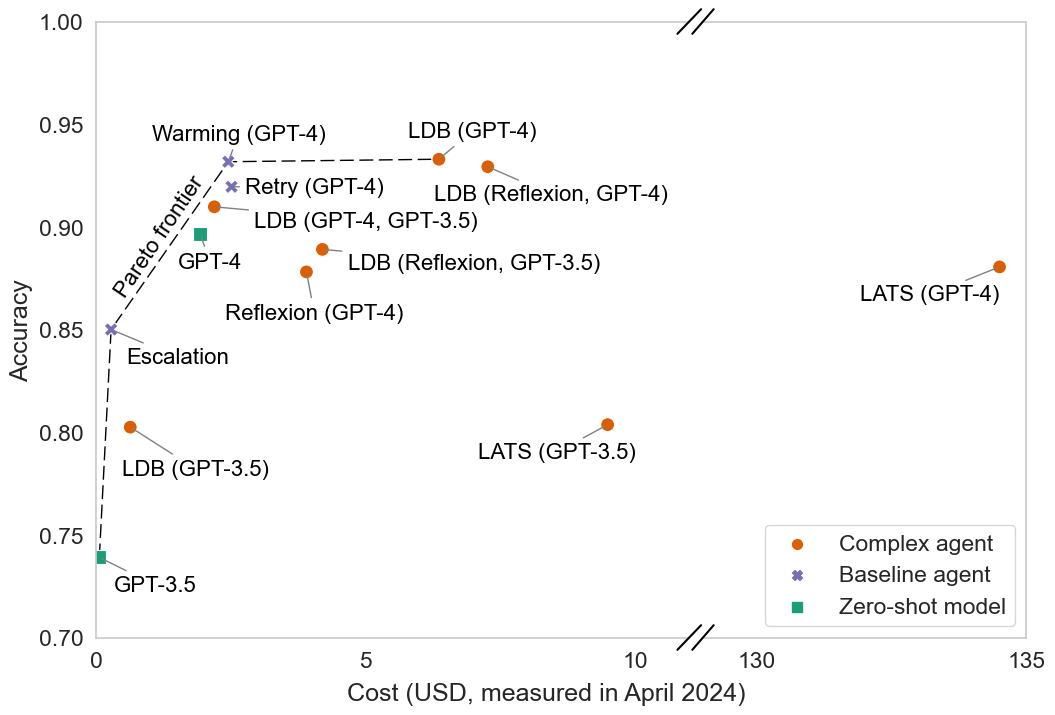

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")
# Set the context for plotting 
sns.set_context("notebook", font_scale=1.5)  #

# Load the data
data = pd.read_csv('plot_data_0409.csv')


# Map the old strategy names to the new names
strategy_renames = {
    "ldb": "LDB",
    "lats": "LATS",
    "simple": "",
    "simple_boosting": "Escalation",
    "simple_incr_temp": "Warming",
    "reflexion": "Reflexion",
    "simple_repeat": "Retry"
}
data['strategy_renamed'] = data['strategy'].map(strategy_renames)

# Replace model names with more readable names
model_renames = {
    "gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-3.5-turbo-0125+gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-2024-04-09+gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-0125": "GPT-4",
    "l3_8b-gpt35-l3_70b-gpt4": "gpt",
    "l3_8b-gpt35-l3_70b-gpt4-0409": "gpt",
    "gpt-4-turbo-0125": "GPT-4",
    "gpt-4-turbo-0409-5step": "GPT-4",
     "gpt-4-turbo-0409-1step": "GPT-4-1step",
     "gpt-4-turbo-0125-8repeats-no-temp-incr": "GPT-4",
     "gpt-4-turbo-2024-04-09+reflexion": "GPT-4+reflexion",
     "gpt-3.5-turbo-0125+reflexion": "GPT-3.5+reflexion",
     "gpt-4-turbo-0409-5repeats-no-temp-incr": "GPT-4",
     "gpt-3.5-turbo-0125+gpt-4-turbo-2024-04-09": "GPT-4, GPT-3.5",
    # "CL > GPT3.5 > GPT4": "CodeLlama"
}

data['model'] = data['model'].map(model_renames)

# Add model name to the strategy name
for i in range(data.shape[0]):
    if strategy_renames[data['strategy'][i]] == "":
        data.loc[i, 'strategy_renamed'] = data['model'][i]
    elif strategy_renames[data['strategy'][i]] == "Escalation":
        data.loc[i, 'strategy_renamed'] = "Escalation"
    else:
        data.loc[i, 'strategy_renamed'] = str(data['strategy_renamed'][i]) + " (" + str(data['model'][i]) + ")"
    #if strategy is ldb and model contains reflexion, then add reflexion to the strategy name
    if data['strategy'][i] == "ldb" and "reflexion" in data['model'][i]:
        data.loc[i, 'strategy_renamed'] = "LDB" + " (" + "Reflexion, " + str(data['model'][i]).replace("+reflexion", "") + ")"




# # Change colors of points based on strategy and model
# scatter_plot = sns.scatterplot(data=data, x='total_cost', y='accuracy', hue='strategy_renamed', palette=color_dict,
#                                 marker='o', s=200, legend=None)


# Group data by model and strategy, calculating mean and error bar ranges
grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    min_accuracy=('accuracy', 'min'),
    max_accuracy=('accuracy', 'max'),
    mean_cost=('total_cost', 'mean')
).reset_index()

# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper'] = grouped_data['max_accuracy'] - grouped_data['mean_accuracy']
grouped_data['yerr_lower'] = grouped_data['mean_accuracy'] - grouped_data['min_accuracy']


# Create the scatter plot with error bars
f, (ax, ax2) = plt.subplots(1,2, figsize=(12, 8), sharey=True, width_ratios=[11, 6])
f.subplots_adjust(wspace=0.03)

scatter_plot = sns.scatterplot(
    data=grouped_data, 
    x='mean_cost', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    # marker='o', 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    ax=ax,
    zorder=2
)
scatter_plot2 = sns.scatterplot(
    data=grouped_data, 
    x='mean_cost', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    # marker='o', 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    ax=ax2,
    zorder=2
)

# # change color of the error bars
# for i in range(len(grouped_data)):
#     plt.errorbar(
#         x=grouped_data['mean_cost'][i], 
#         y=grouped_data['mean_accuracy'][i], 
#         yerr=[[grouped_data['yerr_lower'][i]], [grouped_data['yerr_upper'][i]]], 
#         fmt='o',  # Use the same marker as the scatter plot
#         color=color_dict[grouped_data['strategy_renamed'][i]],  # Use the same color as the scatter plot
#         capsize=0,  # Add caps to the error bars
#         elinewidth=3  # Adjust error bar line width
#     )


# Setting the title and labels
# plt.title('Accuracy vs. Cost per Model and Agent on HumanEval', fontsize=16, pad=15)
ax.set_ylabel('Accuracy')
# set joint x-axis label
f.text(0.5, 0.04, 'Cost (USD, measured in April 2024)', ha='center', va='center')
# remove the x-axis label from the second plot
ax2.set_xlabel('')
ax.set_xlabel('')
plt.grid(True)

# Setting the y-axis limits
plt.ylim(0.7, 1)
ax.set_xlim(0, 11)
ax2.set_xlim(129, 135)
# plt.xscale('log', base=10)

# plot ticks on x axis every 5 units
ax.set_xticks([0,5,10])
ax2.set_xticks([130, 135])

ax.grid(False)
ax2.grid(False)

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), zorder=3, **kwargs)     # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), zorder=3, **kwargs)  # top-right diagonal

d = .02
kwargs.update(transform=ax2.transAxes, color='k', clip_on=False)  # switch to the bottom axes
ax2.plot((-d-0.013, +d+0.013), (- d, + d), zorder=3, **kwargs)  # bottom-left diagonal
ax2.plot((- d-0.013, + d+0.013), (1 - d, 1 + d), zorder=3,**kwargs)  # bottom-right diagonal

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# LEGEND
colors = [orange, green, blue]
labels = ['Complex agent', 'Baseline agent', 'Zero-shot model']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    if color == orange:
        m = 'o'
    elif color == green:
        m = 'X'
    else:
        m = 's'
    handle = plt.scatter([], [], c=color, marker=m, s=50)
    legend_handles.append(handle)
ax2.legend(handles=legend_handles, labels=labels, loc="lower right")

# Define the points for the Pareto frontier line
pareto_color = "black"
pareto_x = [0.054854, 0.273124, 2.448440, 6.355392]
pareto_y = [0.739024, 0.85, 0.931707, 0.932927]
ax.plot(pareto_x, pareto_y, linestyle='dashed', color=pareto_color, zorder=1, linewidth=1, dashes=(10, 4))
ax.text(pareto_x[1]+0.01, pareto_y[1]+0.014, 'Pareto frontier', fontsize=16, color=pareto_color, ha='left', va='bottom', rotation=56) # log scale
# plt.text(pareto_x[0]+0.022, pareto_y[0]+0.035, 'Pareto frontier', fontsize=12, color=pareto_color, ha='left', va='bottom', rotation=54)

data = grouped_data
# Implementing label adjustments using simple lines
for i in range(data.shape[0]):
    annotation_text = data.strategy_renamed[i]
    x = data.mean_cost[i]
    y = data.mean_accuracy[i]
    if data.strategy_renamed[i] == "Escalation":
        xytext = (85, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-3.5":
        xytext = (70, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5)":
        xytext = (100, -30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-3.5)":
        xytext = (90, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-4)":
        xytext = (70, -30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-4)":
        xytext = (130, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-3.5)":
        xytext = (200, -10)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4)":
        xytext = (70, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4, GPT-3.5)":
        xytext = (190, -10)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4)":
        xytext = (70, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4-1step)":
        xytext = (60, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Retry (GPT-4)":
        xytext = (110,0)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-4":
        xytext = (30,-20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-3.5)":
        xytext = (20,-20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-4)":
        xytext = (0,-20)  # "Escalation" above the point
        ha = 'right'
    else:
        xytext = (60, -5)  # other strategies below the point to the right
        ha = 'right'

    scatter_plot.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))
    scatter_plot2.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))

plt.savefig(f"humaneval_figures/pareto-humaneval.png", bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()


#### big fonts

/tmp/ipykernel_2878931/3497647492.py:140: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = plt.scatter([], [], c=color, marker='o')


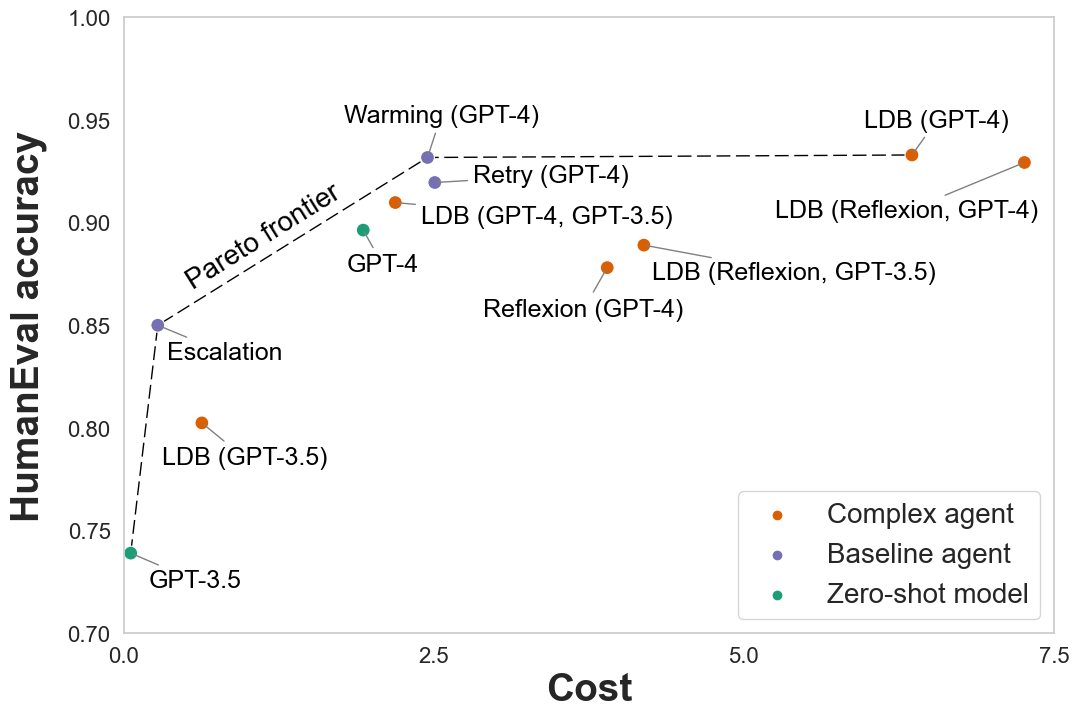

<Figure size 640x480 with 0 Axes>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")
# Set the context for plotting 
sns.set_context("notebook", font_scale=1)  #

# Load the data
data = pd.read_csv('plot_data_0409.csv')

# filter lats gpt-4-turbo-2024-04-09
data = data[~((data['strategy'] == 'lats'))].reset_index(drop=True)


# Map the old strategy names to the new names
strategy_renames = {
    "ldb": "LDB",
    "lats": "LATS",
    "simple": "",
    "simple_boosting": "Escalation",
    "simple_incr_temp": "Warming",
    "reflexion": "Reflexion",
    "simple_repeat": "Retry"
}
data['strategy_renamed'] = data['strategy'].map(strategy_renames)

# Replace model names with more readable names
model_renames = {
    "gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-3.5-turbo-0125+gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-2024-04-09+gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-0125": "GPT-4",
    "l3_8b-gpt35-l3_70b-gpt4": "gpt",
    "l3_8b-gpt35-l3_70b-gpt4-0409": "gpt",
    "gpt-4-turbo-0125": "GPT-4",
    "gpt-4-turbo-0409-5step": "GPT-4",
     "gpt-4-turbo-0409-1step": "GPT-4-1step",
     "gpt-4-turbo-0125-8repeats-no-temp-incr": "GPT-4",
     "gpt-4-turbo-2024-04-09+reflexion": "GPT-4+reflexion",
     "gpt-3.5-turbo-0125+reflexion": "GPT-3.5+reflexion",
     "gpt-4-turbo-0409-5repeats-no-temp-incr": "GPT-4",
     "gpt-3.5-turbo-0125+gpt-4-turbo-2024-04-09": "GPT-4, GPT-3.5",
    # "CL > GPT3.5 > GPT4": "CodeLlama"
}

data['model'] = data['model'].map(model_renames)

# Add model name to the strategy name
for i in range(data.shape[0]):
    if strategy_renames[data['strategy'][i]] == "":
        data.loc[i, 'strategy_renamed'] = data['model'][i]
    elif strategy_renames[data['strategy'][i]] == "Escalation":
        data.loc[i, 'strategy_renamed'] = "Escalation"
    else:
        data.loc[i, 'strategy_renamed'] = str(data['strategy_renamed'][i]) + " (" + str(data['model'][i]) + ")"
    #if strategy is ldb and model contains reflexion, then add reflexion to the strategy name
    if data['strategy'][i] == "ldb" and "reflexion" in data['model'][i]:
        data.loc[i, 'strategy_renamed'] = "LDB" + " (" + "Reflexion, " + str(data['model'][i]).replace("+reflexion", "") + ")"




# # Change colors of points based on strategy and model
# scatter_plot = sns.scatterplot(data=data, x='total_cost', y='accuracy', hue='strategy_renamed', palette=color_dict,
#                                 marker='o', s=200, legend=None)


# Group data by model and strategy, calculating mean and error bar ranges
grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    min_accuracy=('accuracy', 'min'),
    max_accuracy=('accuracy', 'max'),
    mean_cost=('total_cost', 'mean')
).reset_index()

# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper'] = grouped_data['max_accuracy'] - grouped_data['mean_accuracy']
grouped_data['yerr_lower'] = grouped_data['mean_accuracy'] - grouped_data['min_accuracy']


# Create the scatter plot with error bars
# f, (ax, ax2) = plt.subplots(1,1, figsize=(12, 8), sharey=True, width_ratios=[11, 6])
plt.figure(figsize=(12, 8))
f.subplots_adjust(wspace=0.03)

scatter_plot = sns.scatterplot(
    data=grouped_data, 
    x='mean_cost', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    marker='o', 
    s=100, 
    legend=None,
    zorder=2
)


# # change color of the error bars
# for i in range(len(grouped_data)):
#     plt.errorbar(
#         x=grouped_data['mean_cost'][i], 
#         y=grouped_data['mean_accuracy'][i], 
#         yerr=[[grouped_data['yerr_lower'][i]], [grouped_data['yerr_upper'][i]]], 
#         fmt='o',  # Use the same marker as the scatter plot
#         color=color_dict[grouped_data['strategy_renamed'][i]],  # Use the same color as the scatter plot
#         capsize=0,  # Add caps to the error bars
#         elinewidth=3  # Adjust error bar line width
#     )


# Setting the title and labels
# plt.title('Accuracy vs. Cost per Model and Agent on HumanEval', fontsize=16, pad=15)
plt.ylabel('HumanEval accuracy', fontsize=28, weight='bold', labelpad=15)
# set joint x-axis label
# remove the x-axis label from the second plot
plt.xlabel('Cost', weight='bold', fontsize=28)
plt.grid(True)

# Setting the y-axis limits
plt.ylim(0.7, 1)
plt.xlim(0, 7.5)
# plt.xscale('log', base=10)

# plot ticks on x axis every 5 units
plt.xticks([0,2.5,5.0,7.5], size=16)
plt.yticks([0.70,.75,.80,.85,.90,.95, 1], size=16)

plt.grid(False)

# LEGEND
colors = [orange, green, blue]
labels = ['Complex agent', 'Baseline agent', 'Zero-shot model']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    handle = plt.scatter([], [], c=color, marker='o')
    legend_handles.append(handle)
plt.legend(handles=legend_handles, labels=labels, loc="lower right", fontsize=20)

# Define the points for the Pareto frontier line
pareto_color = "black"
pareto_x = [0.054854, 0.273124, 2.448440, 6.355392]
pareto_y = [0.739024, 0.85, 0.931707, 0.932927]
plt.plot(pareto_x, pareto_y, linestyle='dashed', color=pareto_color, zorder=1, linewidth=1, dashes=(10, 4))
plt.text(pareto_x[1]+0.2, pareto_y[1]+0.015, 'Pareto frontier', fontsize=20, color=pareto_color, ha='left', va='bottom', rotation=32) # log scale
# plt.text(pareto_x[0]+0.022, pareto_y[0]+0.035, 'Pareto frontier', fontsize=12, color=pareto_color, ha='left', va='bottom', rotation=54)

data = grouped_data
# Implementing label adjustments using simple lines
for i in range(data.shape[0]):
    annotation_text = data.strategy_renamed[i]
    x = data.mean_cost[i]
    y = data.mean_accuracy[i]
    if data.strategy_renamed[i] == "Escalation":
        xytext = (90, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-3.5":
        xytext = (80, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5)":
        xytext = (90, -25)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-3.5)":
        xytext = (90, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-4)":
        xytext = (55, -30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-4)":
        xytext = (10, -35)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-3.5)":
        xytext = (210, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4)":
        xytext = (70, 25)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4, GPT-3.5)":
        xytext = (200, -10)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4)":
        xytext = (80, 30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4-1step)":
        xytext = (60, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Retry (GPT-4)":
        xytext = (140,5)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-4":
        xytext = (40,-25)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-3.5)":
        xytext = (20,-20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-4)":
        xytext = (0,-20)  # "Escalation" above the point
        ha = 'right'
    else:
        xytext = (60, -5)  # other strategies below the point to the right
        ha = 'right'

    scatter_plot.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=18, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))

plt.show()

plt.savefig('output_figure.png',dpi=300,)


### time

/tmp/ipykernel_2878931/2856111517.py:248: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = plt.scatter([], [], c=color, marker=m, s=50)


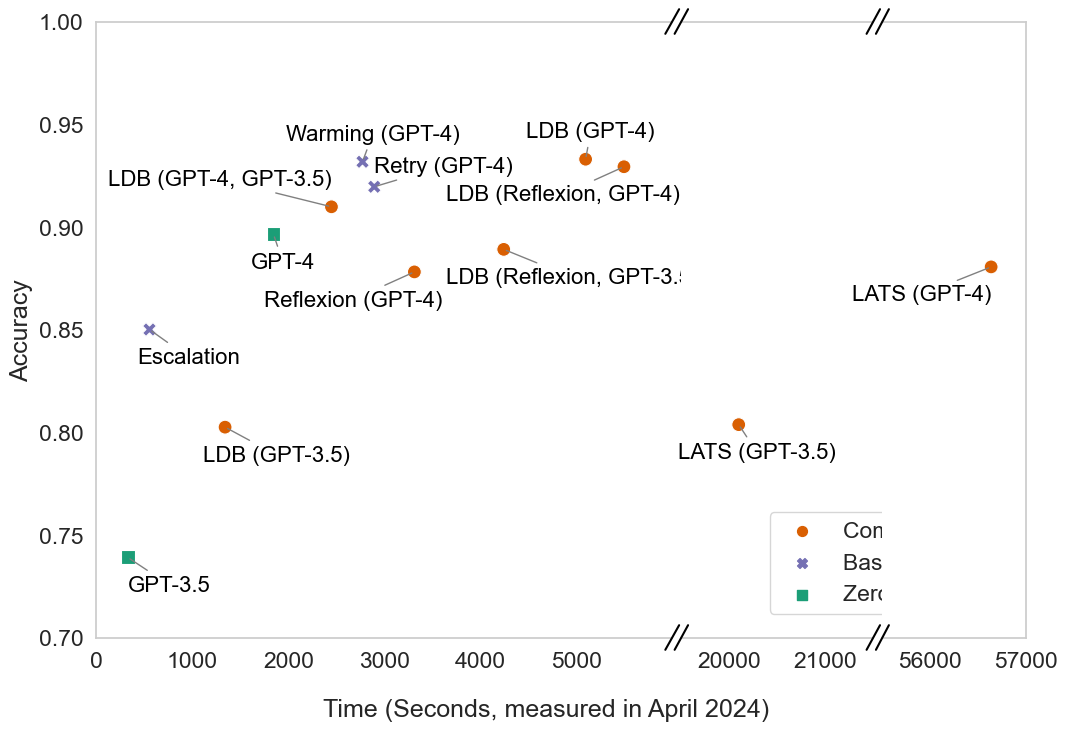

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")
# Set the context for plotting 
sns.set_context("notebook", font_scale=1.5)  #

# Load the data
data = pd.read_csv('plot_data_0409.csv')

data['strategy_renamed'] = data['strategy'].map(strategy_renames)


data['model'] = data['model'].map(model_renames)

# Add model name to the strategy name
for i in range(data.shape[0]):
    if strategy_renames[data['strategy'][i]] == "":
        data.loc[i, 'strategy_renamed'] = data['model'][i]
    elif strategy_renames[data['strategy'][i]] == "Escalation":
        data.loc[i, 'strategy_renamed'] = "Escalation"
    else:
        data.loc[i, 'strategy_renamed'] = str(data['strategy_renamed'][i]) + " (" + str(data['model'][i]) + ")"
    #if strategy is ldb and model contains reflexion, then add reflexion to the strategy name
    if data['strategy'][i] == "ldb" and "reflexion" in data['model'][i]:
        data.loc[i, 'strategy_renamed'] = "LDB" + " (" + "Reflexion, " + str(data['model'][i]).replace("+reflexion", "") + ")"




# # Change colors of points based on strategy and model
# scatter_plot = sns.scatterplot(data=data, x='total_cost', y='accuracy', hue='strategy_renamed', palette=color_dict,
#                                 marker='o', s=200, legend=None)


# Group data by model and strategy, calculating mean and error bar ranges
grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    min_accuracy=('accuracy', 'min'),
    max_accuracy=('accuracy', 'max'),
    mean_time=('total_inference_time', 'mean')
).reset_index()

# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper'] = grouped_data['max_accuracy'] - grouped_data['mean_accuracy']
grouped_data['yerr_lower'] = grouped_data['mean_accuracy'] - grouped_data['min_accuracy']


# Create the scatter plot with error bars
f, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(12, 8), sharey=True, width_ratios=[6, 2, 1.5])
f.subplots_adjust(wspace=0.03)

scatter_plot = sns.scatterplot(
    data=grouped_data, 
    x='mean_time', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    ax=ax,
    zorder=2
)
scatter_plot2 = sns.scatterplot(
    data=grouped_data, 
    x='mean_time', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    ax=ax2,
    zorder=2
)
scatter_plot3 = sns.scatterplot(
    data=grouped_data, 
    x='mean_time', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    ax=ax3,
    zorder=2
)

# # change color of the error bars
# for i in range(len(grouped_data)):
#     plt.errorbar(
#         x=grouped_data['mean_cost'][i], 
#         y=grouped_data['mean_accuracy'][i], 
#         yerr=[[grouped_data['yerr_lower'][i]], [grouped_data['yerr_upper'][i]]], 
#         fmt='o',  # Use the same marker as the scatter plot
#         color=color_dict[grouped_data['strategy_renamed'][i]],  # Use the same color as the scatter plot
#         capsize=0,  # Add caps to the error bars
#         elinewidth=3  # Adjust error bar line width
#     )


# Setting the title and labels
# plt.title('Accuracy vs. Cost per Model and Agent on HumanEval', fontsize=16, pad=15)
ax.set_ylabel('Accuracy')
# set joint x-axis label
f.text(0.5, 0.02, 'Time (Seconds, measured in April 2024)', ha='center', va='center')
# remove the x-axis label from the second plot
ax.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
plt.grid(True)

# Setting the y-axis limits
plt.ylim(0.7, 1)
ax.set_xlim(0, 6000)
ax2.set_xlim(19500, 21500)
ax3.set_xlim(55500, 57000)
# plt.xscale('log', base=10)

ax.grid(False)
ax2.grid(False)
ax3.grid(False)

# plot ticks on x axis every 5 units
ax.set_xticks([0,1000,2000,3000,4000,5000])
ax2.set_xticks([20000,21000])
ax3.set_xticks([56000,57000])

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d+0.008, 1 + d-0.008), (1 - d, 1 + d), zorder=3, **kwargs)     # top-left diagonal
ax.plot((1 - d+0.008, 1 + d-0.008), (-d, +d), zorder=3, **kwargs)  # top-right diagonal

kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((1 - d-0.015, 1 + d+0.015), (1 - d, 1 + d), zorder=3, **kwargs)     # top-left diagonal
ax2.plot((1 - d-0.015, 1 + d+0.015), (-d, +d), zorder=3, **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes, color='k', clip_on=False)  # switch to the bottom axes
ax2.plot((-d-0.015, +d+0.015), (- d, + d), zorder=3, **kwargs)  # bottom-left diagonal
ax2.plot((- d-0.015, + d+0.015), (1 - d, 1 + d), zorder=3,**kwargs)  # bottom-right diagonal

kwargs.update(transform=ax3.transAxes, color='k', clip_on=False)  # switch to the bottom axes
ax3.plot((-d-0.025, +d+0.025), (- d, + d), zorder=3, **kwargs)  # bottom-left diagonal
ax3.plot((- d-0.025, + d+0.025), (1 - d, 1 + d), zorder=3,**kwargs)  # bottom-right diagonal

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)



# Define the points for the Pareto frontier line
# pareto_color = "black"
# pareto_x = [326.559755, 553.508508, 2772.993986]
# pareto_y = [0.739024, 0.85, 0.931707]
# ax.plot(pareto_x, pareto_y, linestyle='dashed', color=pareto_color, zorder=1, linewidth=1, dashes=(10, 4))
# ax.text(pareto_x[1]+0.01, pareto_y[1]+0.006, 'Pareto frontier', fontsize=12, color=pareto_color, ha='left', va='bottom', rotation=33) # log scale
# plt.text(pareto_x[0]+0.022, pareto_y[0]+0.035, 'Pareto frontier', fontsize=12, color=pareto_color, ha='left', va='bottom', rotation=54)

data = grouped_data
# Implementing label adjustments using simple lines
for i in range(data.shape[0]):
    annotation_text = data.strategy_renamed[i]
    x = data.mean_time[i]
    y = data.mean_accuracy[i]
    if data.strategy_renamed[i] == "Escalation":
        xytext = (65, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-3.5":
        xytext = (60, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5)":
        xytext = (90, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-3.5)":
        xytext = (110, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-4)":
        xytext = (20, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-4)":
        xytext = (40, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-3.5)":
        xytext = (140, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4)":
        xytext = (50, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4, GPT-3.5)":
        xytext = (0, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4)":
        xytext = (70, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4-1step)":
        xytext = (60, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Retry (GPT-4)":
        xytext = (100,15)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-4":
        xytext = (30,-20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-3.5)":
        xytext = (70,-20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-4)":
        xytext = (0,-20)  # "Escalation" above the point
        ha = 'right'
    else:
        xytext = (60, -5)  # other strategies below the point to the right
        ha = 'right'

    scatter_plot.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))
    scatter_plot2.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))
    scatter_plot3.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))
    
# LEGEND
colors = [orange, green, blue]
labels = ['Complex agent', 'Baseline agent', 'Zero-shot model']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    if color == orange:
        m = 'o'
    elif color == green:
        m = 'X'
    else:
        m = 's'
    handle = plt.scatter([], [], c=color, marker=m, s=50)
    legend_handles.append(handle)
ax2.legend(handles=legend_handles, labels=labels, bbox_to_anchor=(0.4, 0.02))


plt.savefig(f"humaneval_figures/humaneval-0409-time.png", bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()


### 0613

/tmp/ipykernel_2004606/268490055.py:132: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = plt.scatter([], [], c=color, marker=m, s=50)


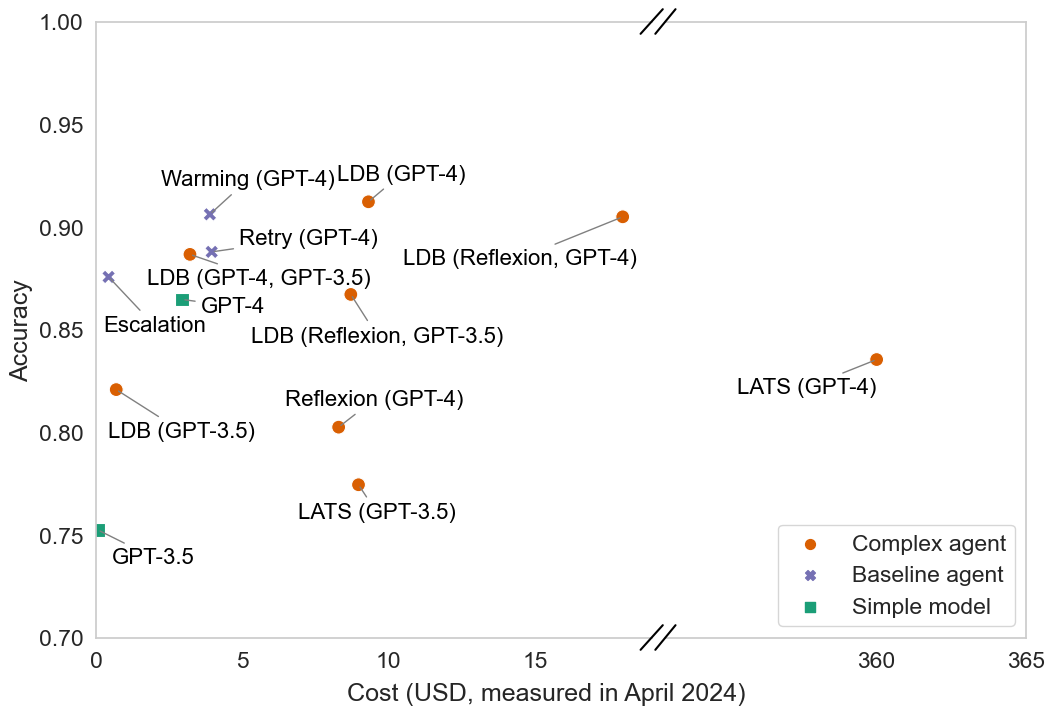

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")
# Set the context for plotting 
sns.set_context("notebook", font_scale=1.5)  #

# Load the data
data = pd.read_csv('plot_data_0613.csv')


# Map the old strategy names to the new names
strategy_renames = {
    "ldb": "LDB",
    "lats": "LATS",
    "simple": "",
    "simple_boosting": "Escalation",
    "simple_incr_temp": "Warming",
    "reflexion": "Reflexion",
    "simple_repeat": "Retry"
}
data['strategy_renamed'] = data['strategy'].map(strategy_renames)

# Replace model names with more readable names
model_renames = {
    "gpt-3.5-turbo-0613": "GPT-3.5",
    "gpt-3.5-turbo-0613+gpt-3.5-turbo-0613": "GPT-3.5",
    "gpt-4-0613": "GPT-4", 
    "gpt-3.5-turbo-0613+reflexion": "GPT-3.5+reflexion",
    "gpt-3.5-turbo-0613+gpt-4-0613": "GPT-4, GPT-3.5",
    "gpt-4-0613+reflexion": "GPT-4+reflexion", 
    "l3_8b-gpt-3.5-turbo-0613-l3_70b-gpt4-0613": "gpt",
    "gpt-4-0613-5repeats-no-temp-incr": "GPT-4",
    "gpt-4-0613+gpt-4-0613": "GPT-4",
    "gpt-4-0613-5step": "GPT-4",
    # "gpt-3.5-turbo-0613-5repeats-no-temp-incr": "GPT-3.5",
    # "CL > GPT3.5 > GPT4": "CodeLlama"
}

data['model'] = data['model'].map(model_renames)

# Add model name to the strategy name
for i in range(data.shape[0]):
    if strategy_renames[data['strategy'][i]] == "":
        data.loc[i, 'strategy_renamed'] = data['model'][i]
    elif strategy_renames[data['strategy'][i]] == "Escalation":
        data.loc[i, 'strategy_renamed'] = "Escalation"
    else:
        data.loc[i, 'strategy_renamed'] = str(data['strategy_renamed'][i]) + " (" + str(data['model'][i]) + ")"
    #if strategy is ldb and model contains reflexion, then add reflexion to the strategy name
    if data['strategy'][i] == "ldb" and "reflexion" in data['model'][i]:
        data.loc[i, 'strategy_renamed'] = "LDB" + " (" + "Reflexion, " + str(data['model'][i]).replace("+reflexion", "") + ")"




# # Change colors of points based on strategy and model
# scatter_plot = sns.scatterplot(data=data, x='total_cost', y='accuracy', hue='strategy_renamed', palette=color_dict,
#                                 marker='o', s=200, legend=None)


# Group data by model and strategy, calculating mean and error bar ranges
grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    min_accuracy=('accuracy', 'min'),
    max_accuracy=('accuracy', 'max'),
    mean_cost=('total_cost', 'mean')
).reset_index()

# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper'] = grouped_data['max_accuracy'] - grouped_data['mean_accuracy']
grouped_data['yerr_lower'] = grouped_data['mean_accuracy'] - grouped_data['min_accuracy']


# Create the scatter plot with error bars
f, (ax, ax2) = plt.subplots(1,2, figsize=(12, 8), sharey=True, width_ratios=[2, 1.3])
f.subplots_adjust(wspace=0.03)

scatter_plot = sns.scatterplot(
    data=grouped_data, 
    x='mean_cost', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    ax=ax,
    zorder=2
)
scatter_plot2 = sns.scatterplot(
    data=grouped_data, 
    x='mean_cost', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    ax=ax2,
    zorder=2
)

# # change color of the error bars
# for i in range(len(grouped_data)):
#     plt.errorbar(
#         x=grouped_data['mean_cost'][i], 
#         y=grouped_data['mean_accuracy'][i], 
#         yerr=[[grouped_data['yerr_lower'][i]], [grouped_data['yerr_upper'][i]]], 
#         fmt='o',  # Use the same marker as the scatter plot
#         color=color_dict[grouped_data['strategy_renamed'][i]],  # Use the same color as the scatter plot
#         capsize=0,  # Add caps to the error bars
#         elinewidth=3  # Adjust error bar line width
#     )

# LEGEND
colors = [orange, green, blue]
labels = ['Complex agent', 'Baseline agent', 'Simple model']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    if color == orange:
        m = 'o'
    elif color == green:
        m = 'X'
    else:
        m = 's'
    handle = plt.scatter([], [], c=color, marker=m, s=50)
    legend_handles.append(handle)
plt.legend(handles=legend_handles, labels=labels, loc="lower right")

# Setting the title and labels
# plt.title('Accuracy vs. Cost per Model and Agent on HumanEval', fontsize=16, pad=15)
ax.set_ylabel('Accuracy')
# set joint x-axis label
f.text(0.5, 0.04, 'Cost (USD, measured in April 2024)', ha='center', va='center')
# remove the x-axis label from the second plot
ax2.set_xlabel('')
ax.set_xlabel('')
plt.grid(True)

# Setting the y-axis limits
plt.ylim(0.7, 1)
ax.set_xlim(0, 19)
ax2.set_xlim(353, 365)
# plt.xscale('log', base=10)

# plot ticks on x axis every 5 units
ax.set_xticks([0,5,10,15])
ax2.set_xticks([360, 365])

ax.grid(False)
ax2.grid(False)

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), zorder=3, **kwargs)     # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), zorder=3, **kwargs)  # top-right diagonal

d = .02
kwargs.update(transform=ax2.transAxes, color='k', clip_on=False)  # switch to the bottom axes
ax2.plot((-d-0.008, +d+0.008), (- d, + d), zorder=3, **kwargs)  # bottom-left diagonal
ax2.plot((- d-0.008, + d+0.008), (1 - d, 1 + d), zorder=3,**kwargs)  # bottom-right diagonal

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Define the points for the Pareto frontier line
# pareto_color = "black"
# pareto_x = [0.041736, 0.418097, 3.883992]
# pareto_y = [0.752439, 0.875610, 0.906098]
# ax.plot(pareto_x, pareto_y, linestyle='dashed', color=pareto_color, zorder=1, linewidth=1, dashes=(10, 4))
# ax.text(pareto_x[1]+0.015, pareto_y[1]+0.005, 'Pareto frontier', fontsize=12, color=pareto_color, ha='left', va='bottom', rotation=32) # log scale
# plt.text(pareto_x[0]+0.022, pareto_y[0]+0.035, 'Pareto frontier', fontsize=12, color=pareto_color, ha='left', va='bottom', rotation=54)

data = grouped_data
# Implementing label adjustments using simple lines
for i in range(data.shape[0]):
    annotation_text = data.strategy_renamed[i]
    x = data.mean_cost[i]
    y = data.mean_accuracy[i]
    if data.strategy_renamed[i] == "Escalation":
        xytext = (70, -35)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-3.5":
        xytext = (70, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5)":
        xytext = (100, -30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-3.5)":
        xytext = (110, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-4)":
        xytext = (90, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-4)":
        xytext = (10, -30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-3.5)":
        xytext = (110, -30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4)":
        xytext = (70, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4, GPT-3.5)":
        xytext = (130, -17)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4)":
        xytext = (90, 25)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4-1step)":
        xytext = (60, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Retry (GPT-4)":
        xytext = (120,10)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-4":
        xytext = (60, -5)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-3.5)":
        xytext = (70,-20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-4)":
        xytext = (0,-20)  # "Escalation" above the point
        ha = 'right'
    else:
        xytext = (60, -5)  # other strategies below the point to the right
        ha = 'right'

    scatter_plot.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))
    scatter_plot2.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))

plt.savefig(f"humaneval_figures/humaneval-0613-acc.png", bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()


### time

/tmp/ipykernel_2581449/2653969662.py:145: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = plt.scatter([], [], c=color, marker=m, s=50)


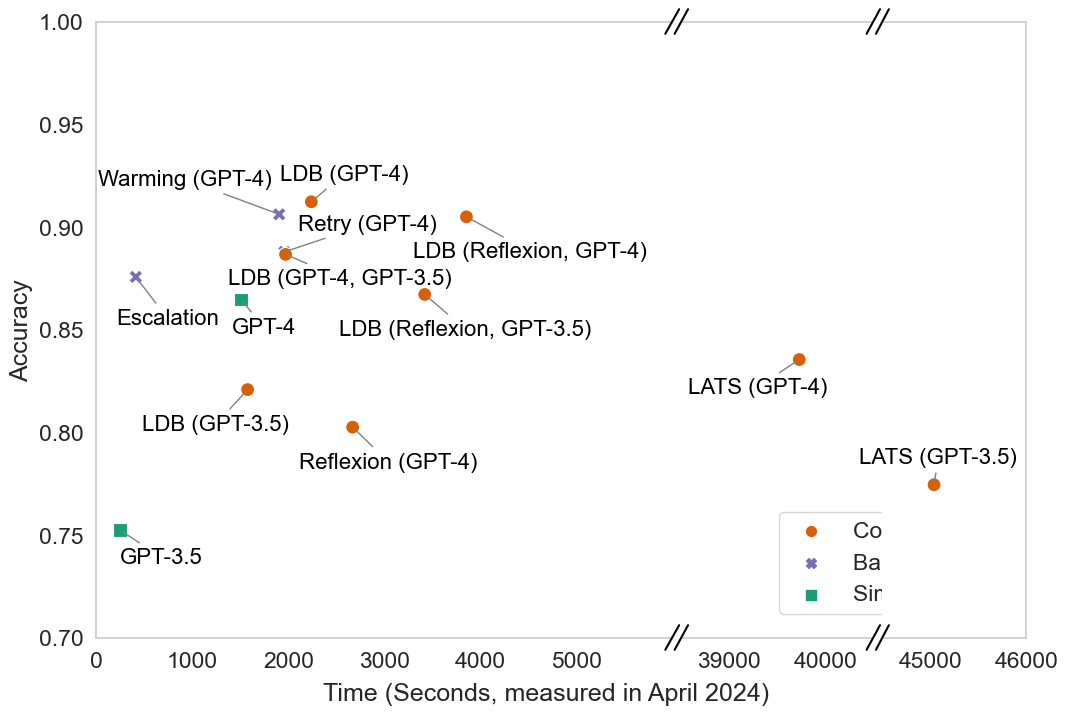

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")
# Set the context for plotting 
sns.set_context("notebook", font_scale=1.5)  #

# Load the data
data = pd.read_csv('plot_data_0613.csv')


# Map the old strategy names to the new names
strategy_renames = {
    "ldb": "LDB",
    "lats": "LATS",
    "simple": "",
    "simple_boosting": "Escalation",
    "simple_incr_temp": "Warming",
    "reflexion": "Reflexion",
    "simple_repeat": "Retry"
}
data['strategy_renamed'] = data['strategy'].map(strategy_renames)

# Replace model names with more readable names
model_renames = {
    "gpt-3.5-turbo-0613": "GPT-3.5",
    "gpt-3.5-turbo-0613+gpt-3.5-turbo-0613": "GPT-3.5",
    "gpt-4-0613": "GPT-4", 
    "gpt-3.5-turbo-0613+reflexion": "GPT-3.5+reflexion",
    "gpt-3.5-turbo-0613+gpt-4-0613": "GPT-4, GPT-3.5",
    "gpt-4-0613+reflexion": "GPT-4+reflexion", 
    "l3_8b-gpt-3.5-turbo-0613-l3_70b-gpt4-0613": "gpt",
    "gpt-4-0613-5repeats-no-temp-incr": "GPT-4",
    "gpt-4-0613+gpt-4-0613": "GPT-4",
    "gpt-4-0613-5step": "GPT-4",
    # "gpt-3.5-turbo-0613-5repeats-no-temp-incr": "GPT-3.5",
    # "CL > GPT3.5 > GPT4": "CodeLlama"
}

data['model'] = data['model'].map(model_renames)

# Add model name to the strategy name
for i in range(data.shape[0]):
    if strategy_renames[data['strategy'][i]] == "":
        data.loc[i, 'strategy_renamed'] = data['model'][i]
    elif strategy_renames[data['strategy'][i]] == "Escalation":
        data.loc[i, 'strategy_renamed'] = "Escalation"
    else:
        data.loc[i, 'strategy_renamed'] = str(data['strategy_renamed'][i]) + " (" + str(data['model'][i]) + ")"
    #if strategy is ldb and model contains reflexion, then add reflexion to the strategy name
    if data['strategy'][i] == "ldb" and "reflexion" in data['model'][i]:
        data.loc[i, 'strategy_renamed'] = "LDB" + " (" + "Reflexion, " + str(data['model'][i]).replace("+reflexion", "") + ")"




# # Change colors of points based on strategy and model
# scatter_plot = sns.scatterplot(data=data, x='total_cost', y='accuracy', hue='strategy_renamed', palette=color_dict,
#                                 marker='o', s=200, legend=None)


# Group data by model and strategy, calculating mean and error bar ranges
grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    min_accuracy=('accuracy', 'min'),
    max_accuracy=('accuracy', 'max'),
    mean_time=('total_inference_time', 'mean')
).reset_index()

# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper'] = grouped_data['max_accuracy'] - grouped_data['mean_accuracy']
grouped_data['yerr_lower'] = grouped_data['mean_accuracy'] - grouped_data['min_accuracy']


# Create the scatter plot with error bars
f, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(12, 8), sharey=True, width_ratios=[6, 2, 1.5])
f.subplots_adjust(wspace=0.03)

scatter_plot = sns.scatterplot(
    data=grouped_data, 
    x='mean_time', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    ax=ax,
    zorder=2
)
scatter_plot2 = sns.scatterplot(
    data=grouped_data, 
    x='mean_time', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    ax=ax2,
    zorder=2
)
scatter_plot3 = sns.scatterplot(
    data=grouped_data, 
    x='mean_time', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None,
    ax=ax3,
    zorder=2
)

# # change color of the error bars
# for i in range(len(grouped_data)):
#     plt.errorbar(
#         x=grouped_data['mean_cost'][i], 
#         y=grouped_data['mean_accuracy'][i], 
#         yerr=[[grouped_data['yerr_lower'][i]], [grouped_data['yerr_upper'][i]]], 
#         fmt='o',  # Use the same marker as the scatter plot
#         color=color_dict[grouped_data['strategy_renamed'][i]],  # Use the same color as the scatter plot
#         capsize=0,  # Add caps to the error bars
#         elinewidth=3  # Adjust error bar line width
#     )

# LEGEND
colors = [orange, green, blue]
labels = ['Complex agent', 'Baseline agent', 'Simple model']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    if color == orange:
        m = 'o'
    elif color == green:
        m = 'X'
    else:
        m = 's'
    handle = plt.scatter([], [], c=color, marker=m, s=50)
    legend_handles.append(handle)
ax2.legend(handles=legend_handles, labels=labels, bbox_to_anchor=(0.45, 0.02))

# Setting the title and labels
# plt.title('Accuracy vs. Cost per Model and Agent on HumanEval', fontsize=16, pad=15)
ax.set_ylabel('Accuracy')
# set joint x-axis label
f.text(0.5, 0.04, 'Time (Seconds, measured in April 2024)', ha='center', va='center')
# remove the x-axis label from the second plot
ax.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
plt.grid(True)

# Setting the y-axis limits
plt.ylim(0.7, 1)
ax.set_xlim(0, 6000)
ax2.set_xlim(38500, 40500)
ax3.set_xlim(44500, 46000)
# plt.xscale('log', base=10)

# plot ticks on x axis every 5 units
ax.set_xticks([0,1000,2000,3000,4000,5000])
ax2.set_xticks([39000,40000])
ax3.set_xticks([45000,46000])

ax.grid(False)
ax2.grid(False)
ax3.grid(False)

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d+0.008, 1 + d-0.008), (1 - d, 1 + d), zorder=3, **kwargs)     # top-left diagonal
ax.plot((1 - d+0.008, 1 + d-0.008), (-d, +d), zorder=3, **kwargs)  # top-right diagonal

kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((1 - d-0.015, 1 + d+0.015), (1 - d, 1 + d), zorder=3, **kwargs)     # top-left diagonal
ax2.plot((1 - d-0.015, 1 + d+0.015), (-d, +d), zorder=3, **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes, color='k', clip_on=False)  # switch to the bottom axes
ax2.plot((-d-0.015, +d+0.015), (- d, + d), zorder=3, **kwargs)  # bottom-left diagonal
ax2.plot((- d-0.015, + d+0.015), (1 - d, 1 + d), zorder=3,**kwargs)  # bottom-right diagonal

kwargs.update(transform=ax3.transAxes, color='k', clip_on=False)  # switch to the bottom axes
ax3.plot((-d-0.025, +d+0.025), (- d, + d), zorder=3, **kwargs)  # bottom-left diagonal
ax3.plot((- d-0.025, + d+0.025), (1 - d, 1 + d), zorder=3,**kwargs)  # bottom-right diagonal

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

# Define the points for the Pareto frontier line
# pareto_color = "black"
# pareto_x = [326.559755, 553.508508, 2772.993986]
# pareto_y = [0.739024, 0.85, 0.931707]
# ax.plot(pareto_x, pareto_y, linestyle='dashed', color=pareto_color, zorder=1, linewidth=1, dashes=(10, 4))
# ax.text(pareto_x[1]+0.01, pareto_y[1]+0.006, 'Pareto frontier', fontsize=12, color=pareto_color, ha='left', va='bottom', rotation=33) # log scale
# plt.text(pareto_x[0]+0.022, pareto_y[0]+0.035, 'Pareto frontier', fontsize=12, color=pareto_color, ha='left', va='bottom', rotation=54)


data = grouped_data
# Implementing label adjustments using simple lines
for i in range(data.shape[0]):
    annotation_text = data.strategy_renamed[i]
    x = data.mean_time[i]
    y = data.mean_accuracy[i]
    if data.strategy_renamed[i] == "Escalation":
        xytext = (60, -30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-3.5":
        xytext = (60, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5)":
        xytext = (30, -25)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-3.5)":
        xytext = (110, -25)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-4)":
        xytext = (90, -25)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-4)":
        xytext = (130, -25)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-3.5)":
        xytext = (120, -25)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4)":
        xytext = (70, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4, GPT-3.5)":
        xytext = (120, -17)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4)":
        xytext = (-5, 25)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4-1step)":
        xytext = (20, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Retry (GPT-4)":
        xytext = (110,20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-4":
        xytext = (40,-20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-3.5)":
        xytext = (60,20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-4)":
        xytext = (20,-20)  # "Escalation" above the point
        ha = 'right'
    else:
        xytext = (60, -5)  # other strategies below the point to the right
        ha = 'right'

    scatter_plot.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))
    scatter_plot2.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))
    scatter_plot3.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=16, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))
plt.savefig(f"humaneval_figures/humaneval-0613-time.png", bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()


## with LATS full y scale

### 0409

/tmp/ipykernel_2581449/4099341745.py:108: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = plt.scatter([], [], c=color, marker=m, s=50)


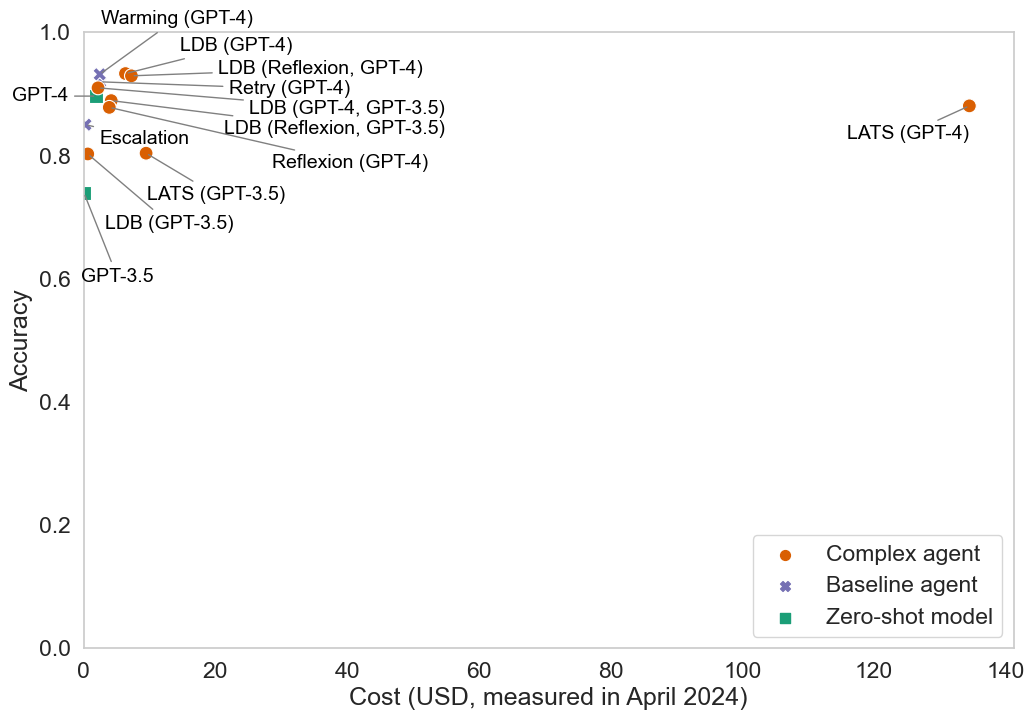

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")
# Set the context for plotting 
sns.set_context("notebook", font_scale=1.5)  #

# Load the data
data = pd.read_csv('plot_data_0409.csv')


# Map the old strategy names to the new names
strategy_renames = {
    "ldb": "LDB",
    "lats": "LATS",
    "simple": "",
    "simple_boosting": "Escalation",
    "simple_incr_temp": "Warming",
    "reflexion": "Reflexion",
    "simple_repeat": "Retry"
}
data['strategy_renamed'] = data['strategy'].map(strategy_renames)

# Replace model names with more readable names
model_renames = {
    "gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-3.5-turbo-0125+gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-2024-04-09+gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-0125": "GPT-4",
    "l3_8b-gpt35-l3_70b-gpt4": "gpt",
    "l3_8b-gpt35-l3_70b-gpt4-0409": "gpt",
    "gpt-4-turbo-0125": "GPT-4",
    "gpt-4-turbo-0409-5step": "GPT-4",
     "gpt-4-turbo-0409-1step": "GPT-4-1step",
     "gpt-4-turbo-0125-8repeats-no-temp-incr": "GPT-4",
     "gpt-4-turbo-2024-04-09+reflexion": "GPT-4+reflexion",
     "gpt-3.5-turbo-0125+reflexion": "GPT-3.5+reflexion",
     "gpt-4-turbo-0409-5repeats-no-temp-incr": "GPT-4",
     "gpt-3.5-turbo-0125+gpt-4-turbo-2024-04-09": "GPT-4, GPT-3.5",
    # "CL > GPT3.5 > GPT4": "CodeLlama"
}

data['model'] = data['model'].map(model_renames)

# Add model name to the strategy name
for i in range(data.shape[0]):
    if strategy_renames[data['strategy'][i]] == "":
        data.loc[i, 'strategy_renamed'] = data['model'][i]
    elif strategy_renames[data['strategy'][i]] == "Escalation":
        data.loc[i, 'strategy_renamed'] = "Escalation"
    else:
        data.loc[i, 'strategy_renamed'] = str(data['strategy_renamed'][i]) + " (" + str(data['model'][i]) + ")"
    #if strategy is ldb and model contains reflexion, then add reflexion to the strategy name
    if data['strategy'][i] == "ldb" and "reflexion" in data['model'][i]:
        data.loc[i, 'strategy_renamed'] = "LDB" + " (" + "Reflexion, " + str(data['model'][i]).replace("+reflexion", "") + ")"




# # Change colors of points based on strategy and model
# scatter_plot = sns.scatterplot(data=data, x='total_cost', y='accuracy', hue='strategy_renamed', palette=color_dict,
#                                 marker='o', s=200, legend=None)


# Group data by model and strategy, calculating mean and error bar ranges
grouped_data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    min_accuracy=('accuracy', 'min'),
    max_accuracy=('accuracy', 'max'),
    mean_cost=('total_cost', 'mean')
).reset_index()

# Calculate error bar values (max - mean and mean - min)
grouped_data['yerr_upper'] = grouped_data['max_accuracy'] - grouped_data['mean_accuracy']
grouped_data['yerr_lower'] = grouped_data['mean_accuracy'] - grouped_data['min_accuracy']


# Create the scatter plot with error bars
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    data=grouped_data, 
    x='mean_cost', 
    y='mean_accuracy', 
    hue='strategy_renamed', 
    palette=color_dict, 
    style='strategy_renamed',
    markers=markers_dict,
    s=100, 
    legend=None
)


# LEGEND
colors = [orange, green, blue]
labels = ['Complex agent', 'Baseline agent', 'Zero-shot model']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    if color == orange:
        m = 'o'
    elif color == green:
        m = 'X'
    else:
        m = 's'
    handle = plt.scatter([], [], c=color, marker=m, s=50)
    legend_handles.append(handle)
plt.legend(handles=legend_handles, labels=labels, loc="lower right")

# Setting the title and labels
# plt.title('Accuracy vs. Cost per Model and Agent on HumanEval', fontsize=16, pad=15)
plt.xlabel('Cost (USD, measured in April 2024)')
plt.ylabel('Accuracy')
plt.grid(True)


# Setting the y-axis limits
plt.ylim(0, 1)
plt.xlim(0,)
# plt.xscale('log', base=10)

plt.grid(False)

data = grouped_data
# Implementing label adjustments using simple lines
for i in range(data.shape[0]):
    annotation_text = data.strategy_renamed[i]
    x = data.mean_cost[i]
    y = data.mean_accuracy[i]
    if data.strategy_renamed[i] == "Escalation":
        xytext = (75, -10)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-3.5":
        xytext = (50, -60)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-3.5)":
        xytext = (105, -50)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-3.5)":
        xytext = (110, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Reflexion (GPT-4)":
        xytext = (230, -40)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-4)":
        xytext = (210, 5)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (Reflexion, GPT-3.5)":
        xytext = (240, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4)":
        xytext = (120, 20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LDB (GPT-4, GPT-3.5)":
        xytext = (250, -15)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4)":
        xytext = (110, 40)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Warming (GPT-4-1step)":
        xytext = (60, -20)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "Retry (GPT-4)":
        xytext = (180,-5)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "GPT-4":
        xytext = (-20,0)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-3.5)":
        xytext = (100,-30)  # "Escalation" above the point
        ha = 'right'
    elif data.strategy_renamed[i] == "LATS (GPT-4)":
        xytext = (0,-20)  # "Escalation" above the point
        ha = 'right'
    else:
        xytext = (60, -5)  # other strategies below the point to the right
        ha = 'right'

    scatter_plot.annotate(annotation_text, xy=(x, y), xycoords='data',
                          xytext=xytext, textcoords='offset points',
                          size=14, ha=ha, va='center', color='black',
                          arrowprops=dict(arrowstyle="-", color='gray'))

plt.savefig(f"humaneval_figures/humaneval-0409-fullaxes.png", bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()


## data export for webapp

In [ ]:
data = pd.read_csv('plot_data_0409.csv')


# Map the old strategy names to the new names
strategy_renames = {
    "ldb": "LDB",
    "lats": "LATS",
    "simple": "",
    "simple_boosting": "Escalation",
    "simple_incr_temp": "Warming",
    "reflexion": "Reflexion",
    "simple_repeat": "Retry"
}
data['strategy_renamed'] = data['strategy'].map(strategy_renames)

# Replace model names with more readable names
model_renames = {
    "gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-3.5-turbo-0125+gpt-3.5-turbo-0125": "GPT-3.5",
    "gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-2024-04-09+gpt-4-turbo-2024-04-09": "GPT-4",
    "gpt-4-turbo-0125": "GPT-4",
    "l3_8b-gpt35-l3_70b-gpt4": "gpt",
    "l3_8b-gpt35-l3_70b-gpt4-0409": "gpt",
    "gpt-4-turbo-0125": "GPT-4",
    "gpt-4-turbo-0409-5step": "GPT-4",
     "gpt-4-turbo-0409-1step": "GPT-4-1step",
     "gpt-4-turbo-0125-8repeats-no-temp-incr": "GPT-4",
     "gpt-4-turbo-2024-04-09+reflexion": "GPT-4+reflexion",
     "gpt-3.5-turbo-0125+reflexion": "GPT-3.5+reflexion",
     "gpt-4-turbo-0409-5repeats-no-temp-incr": "GPT-4",
     "gpt-3.5-turbo-0125+gpt-4-turbo-2024-04-09": "GPT-4, GPT-3.5",
    # "CL > GPT3.5 > GPT4": "CodeLlama"
}

data['model'] = data['model'].map(model_renames)

# Add model name to the strategy name
for i in range(data.shape[0]):
    if strategy_renames[data['strategy'][i]] == "":
        data.loc[i, 'strategy_renamed'] = data['model'][i]
    elif strategy_renames[data['strategy'][i]] == "Escalation":
        data.loc[i, 'strategy_renamed'] = "Escalation"
    else:
        data.loc[i, 'strategy_renamed'] = str(data['strategy_renamed'][i]) + " (" + str(data['model'][i]) + ")"
    #if strategy is ldb and model contains reflexion, then add reflexion to the strategy name
    if data['strategy'][i] == "ldb" and "reflexion" in data['model'][i]:
        data.loc[i, 'strategy_renamed'] = "LDB" + " (" + "Reflexion, " + str(data['model'][i]).replace("+reflexion", "") + ")"


# Group data by model and strategy, calculating mean and error bar ranges
data = data.groupby(['model', 'strategy_renamed']).agg(
    mean_accuracy=('accuracy', 'mean'),
    min_accuracy=('accuracy', 'min'),
    max_accuracy=('accuracy', 'max'),
    mean_prompt_tokens=('total_prompt_tokens', 'mean'),
    mean_completion_tokens=('total_completion_tokens', 'mean'),
    mean_l3_8b_prompt_tokens=('total_l3_8b_prompt_tokens', 'mean'),
    mean_l3_8b_completion_tokens=('total_l3_8b_completion_tokens', 'mean'),
    mean_l3_70b_prompt_tokens=('total_l3_70b_prompt_tokens', 'mean'),
    mean_l3_70b_completion_tokens=('total_l3_70b_completion_tokens', 'mean'),
    mean_gpt_35_prompt_tokens=('total_gpt_35_prompt_tokens', 'mean'),
    mean_gpt_35_completion_tokens=('total_gpt_35_completion_tokens', 'mean'),
    mean_gpt_4_prompt_tokens=('total_gpt_4_prompt_tokens', 'mean'),
    mean_gpt_4_completion_tokens=('total_gpt_4_completion_tokens', 'mean'),
).reset_index()
data.to_json('data.json', orient='records')